In this document, we first extract learners' mind-wandering from the json data. Then we map the data on the timeline. We process the mind-wandering data generated by reporting and questions seperately.

## 1. Data Reading
In this step, we read gaze data of Tobii from a tsv file and mind-wandering reports from a json file.

In [11]:
import pandas as pd
import numpy as np
from pandas import DataFrame

folderpath_tobiidata = "../Data_Publish/Data_Tobii/Data_Raw"
folderpath_tobiidata_sd = "../Data_Publish/Data_Tobii/Data_ProcessedByScript02"
folderpath_webgazer = "../Data_Publish/Data_WebGazer/Data_ProcessedByScript02"
folderpath_webgazerdata = "../Data_Publish/Data_Event"

### 1.1 Reading Mind-Wandering Data
We only read some important data columns from the json file.

1. Rating
2. Bell Rings

In [12]:
import json
import os

list_filepath_report = []
list_id_report = []
for file in os.listdir(folderpath_webgazerdata):
    if file.endswith(".json"):
        list_filepath_report.append(os.path.join(folderpath_webgazerdata, file))
        list_id_report.append(file[0:-5])
        
print list_filepath_report
print list_id_report

['../Data_Publish/Data_Event/Anon01.json', '../Data_Publish/Data_Event/Anon02.json', '../Data_Publish/Data_Event/Anon03.json', '../Data_Publish/Data_Event/Anon04.json', '../Data_Publish/Data_Event/Anon05.json', '../Data_Publish/Data_Event/Anon06.json', '../Data_Publish/Data_Event/Anon07.json', '../Data_Publish/Data_Event/Anon08.json', '../Data_Publish/Data_Event/Anon09.json', '../Data_Publish/Data_Event/Anon10.json', '../Data_Publish/Data_Event/Anon11.json', '../Data_Publish/Data_Event/Anon12.json', '../Data_Publish/Data_Event/Anon13.json']
['Anon01', 'Anon02', 'Anon03', 'Anon04', 'Anon05', 'Anon06', 'Anon07', 'Anon08', 'Anon09', 'Anon10', 'Anon11', 'Anon12', 'Anon13']


#### Data Format 
id, starttime_iso, endtime_iso, starttime_video, endtime_video, video_length, label

In [13]:
import datetime

df_reports = pd.DataFrame()

for i in range(0, len(list_id_report)):
    # id
    id_str = list_id_report[i]
    print id_str
    # starttime_iso, endtime_iso, starttime_video, endtime_video, video_length, label
    with open(list_filepath_report[i]) as file_json_data:
        json_data = json.load(file_json_data)
        # print(json_data['activity'])
        
        # TODO: full screen playing info
        fullscreen_list = []
        fullscreen_temp = {'enter': '', 'exit': ''}
        for videostatus in json_data['user']['videostatus']:
            if videostatus['status'] == 'Fullscreen_enter':
                fullscreen_temp = {'enter': '', 'exit': ''}
                fullscreen_temp['enter'] = videostatus['time']
            elif videostatus['status'] == 'Fullscreen_exit':
                if (fullscreen_temp['enter'] != ''):
                    fullscreen_temp['exit'] = videostatus['time']
                    fullscreen_list.append(fullscreen_temp)
                    fullscreen_temp = {'enter': '', 'exit': ''}
            elif videostatus['status'] == 'ENDED':
                if (fullscreen_temp['enter'] != ''):
                    fullscreen_temp['exit'] = videostatus['time']
                    fullscreen_list.append(fullscreen_temp)
                    fullscreen_temp = {'enter': '', 'exit': ''}           
        
        print fullscreen_list
        
        pre_video_id = ""
        video_order = 1
        
        for bell in json_data['user']['ratingbells']:
            ## End time is the time when bell rings
            endtime_iso = bell['time']
            # print endtime_iso
            endtime_iso_datetime = datetime.datetime.strptime(endtime_iso, "%Y-%m-%dT%H:%M:%S.%fZ")
            ## Start time is 30 sec before the end time
            starttime_iso_datetime = endtime_iso_datetime - datetime.timedelta(seconds=30)
            (dt, micro) = starttime_iso_datetime.strftime('%Y-%m-%dT%H:%M:%S.%f').split('.')
            starttime_iso = "%s.%03dZ" % (dt, int(micro) / 1000)
            # print starttime_iso
            
            endtime_video = bell['videoTime']
            # print endtime_video
            ## There is no stop in last 30 sec before the bell rings. 
            ## Since each time the video playing starts, they will ring the bell after 30 sec.
            starttime_video = str(float(endtime_video) - 30)
            # print starttime_video
            
            video_length = bell['videoDuration']
            # print video_length

            video_id = ""           
            if float(video_length) < 420:
                video_id = "Nuclear"  
            else:
                video_id = "Solar"
            
            if pre_video_id == "":
                video_order = 1
                pre_video_id = video_id
            elif video_id != pre_video_id:
                video_order = video_order + 1
                pre_video_id = video_id
            
            label = 0
            for rating in json_data['user']['ratings']:
                ratingtime_iso = rating['time']
                # print ratingtime_iso
                ratingtime_iso_datetime = datetime.datetime.strptime(ratingtime_iso, "%Y-%m-%dT%H:%M:%S.%fZ")
                if ratingtime_iso_datetime > endtime_iso_datetime and ratingtime_iso_datetime < endtime_iso_datetime + datetime.timedelta(seconds=10):
                    label = 1
                    break
            # print label          
            
            fullscreen_flag = 0
            for fullscreen_play in fullscreen_list:
                if (starttime_iso > fullscreen_play['enter']) and (endtime_iso < fullscreen_play['exit']):
                    fullscreen_flag = 1
                    break
            
            ## Add data into dataframe
            df_reports = df_reports.append({'id': id_str,
                                            'video_id': video_id,
                                            'video_order': video_order,
                                            'starttime_iso': starttime_iso, 
                                            'endtime_iso': endtime_iso,
                                            'starttime_video': starttime_video,
                                            'endtime_video': endtime_video,
                                            'video_length': video_length,
                                            'label': label,
                                            'fullscreen': fullscreen_flag
                                           }, 
                                           ignore_index=True)
print df_reports.head(10)
print df_reports.shape
print df_reports[df_reports['label'] == 1].shape
print df_reports[df_reports['label'] == 0].shape
print df_reports.video_order.values
print df_reports.video_id.values
df_reports.to_csv("report_info.csv", index=False)

Anon01
[]
Anon02
[{'exit': u'2017-04-12T11:28:33.178Z', 'enter': u'2017-04-12T11:20:41.610Z'}, {'exit': u'2017-04-12T11:40:20.780Z', 'enter': u'2017-04-12T11:33:36.025Z'}]
Anon03
[]
Anon04
[{'exit': u'2017-04-06T11:53:39.676Z', 'enter': u'2017-04-06T11:45:46.491Z'}, {'exit': u'2017-04-06T12:05:42.023Z', 'enter': u'2017-04-06T11:58:57.059Z'}]
Anon05
[]
Anon06
[]
Anon07
[{'exit': u'2017-04-13T12:45:32.365Z', 'enter': u'2017-04-13T12:38:52.824Z'}, {'exit': u'2017-04-13T12:59:46.088Z', 'enter': u'2017-04-13T12:51:58.970Z'}]
Anon08
[]
Anon09
[]
Anon10
[]
Anon11
[]
Anon12
[{'exit': u'2017-04-12T15:37:00.416Z', 'enter': u'2017-04-12T15:30:23.180Z'}, {'exit': u'2017-04-12T15:48:18.222Z', 'enter': u'2017-04-12T15:40:29.354Z'}]
Anon13
[{'exit': u'2017-04-12T14:32:31.031Z', 'enter': u'2017-04-12T14:24:43.184Z'}, {'exit': u'2017-04-12T14:43:27.772Z', 'enter': u'2017-04-12T14:36:46.908Z'}]
                endtime_iso       endtime_video  fullscreen      id  label  \
0  2017-04-12T09:28:47.772Z     

### 1.2 Reading Video Playing Data
We only read some important data columns from the json file.

In [14]:
import datetime

df_videos = pd.DataFrame()

for i in range(0, len(list_id_report)):
    # id
    id_str = list_id_report[i]
    print id_str
    # starttime_iso, endtime_iso, starttime_video, endtime_video, video_length, label
    with open(list_filepath_report[i]) as file_json_data:
        json_data = json.load(file_json_data)
        # print(json_data['activity'])
        
        # full screen playing info
        time_video_1_start = ""
        time_video_1_end = ""
        time_video_2_start = ""
        time_video_2_end = ""
        video_1_length = ""
        video_2_length = ""
        temp_current_stage = ""
        for videostatus in json_data['user']['videostatus']:
            if videostatus['status'] == 'PLAYING':
                video_stage = videostatus['stage']
                if video_stage == temp_current_stage:
                    continue
                else:
                    if time_video_1_start == "":
                        time_video_1_start = videostatus['time']
                        temp_current_stage = videostatus['stage']
                        video_1_length = videostatus['videoDuration']
                    else:
                        time_video_2_start = videostatus['time']
                        temp_current_stage = videostatus['stage']
                        video_2_length = videostatus['videoDuration']
            elif videostatus['status'] == 'ENDED':
                video_stage = videostatus['stage']
                if video_stage == temp_current_stage:
                    if time_video_1_start != "" and time_video_1_end == "":
                        time_video_1_end = videostatus['time']
                    elif time_video_2_start != "" and time_video_2_end == "":
                        time_video_2_end = videostatus['time']
            else:
                continue          
        
        print time_video_1_start
        print time_video_1_end
        print video_1_length
        print time_video_2_start
        print time_video_2_end
        print video_2_length
        
        video_id_1 = ""           
        if float(video_1_length) < 420:
            video_id_1 = "Nuclear"  
        else:
            video_id_1 = "Solar"
            
        video_id_2 = ""           
        if float(video_2_length) < 420:
            video_id_2 = "Nuclear"  
        else:
            video_id_2 = "Solar"
        
        ## Add data into dataframe
        df_videos = df_videos.append({'id': id_str,
                                      'video_id': video_id_1,
                                      'video_order': "1",
                                      'starttime_iso': time_video_1_start, 
                                      'endtime_iso': time_video_1_end,
                                      'video_length': video_1_length
                                     }, ignore_index=True)
        df_videos = df_videos.append({'id': id_str,
                                      'video_id': video_id_2,
                                      'video_order': "2",
                                      'starttime_iso': time_video_2_start, 
                                      'endtime_iso': time_video_2_end,
                                      'video_length': video_2_length
                                     }, ignore_index=True)

print df_videos.head(10)
print df_videos.shape
df_videos.to_csv("video_info.csv", index=False)

Anon01
2017-04-12T09:28:08.749Z
2017-04-12T09:34:50.144Z
400.921
2017-04-12T09:39:47.107Z
2017-04-12T09:47:35.626Z
468.0214058956916
Anon02
2017-04-12T11:20:44.578Z
2017-04-12T11:28:33.178Z
468
2017-04-12T11:33:39.393Z
2017-04-12T11:40:20.780Z
400.921
Anon03
2017-04-10T12:45:21.001Z
2017-04-10T12:53:09.888Z
468.0214058956916
2017-04-10T12:57:51.794Z
2017-04-10T13:04:33.168Z
400.921
Anon04
2017-04-06T11:45:50.625Z
2017-04-06T11:53:39.676Z
468
2017-04-06T11:59:00.572Z
2017-04-06T12:05:42.023Z
401
Anon05
2017-04-10T14:10:36.526Z
2017-04-10T14:17:17.908Z
400.921
2017-04-10T14:21:29.571Z
2017-04-10T14:29:17.675Z
468.0214058956916
Anon06
2017-04-10T15:57:07.614Z
2017-04-10T16:03:49.003Z
400.921
2017-04-10T16:08:44.041Z
2017-04-10T16:16:32.553Z
468.0214058956916
Anon07
2017-04-13T12:38:50.946Z
2017-04-13T12:45:32.365Z
400.921
2017-04-13T12:51:57.497Z
2017-04-13T12:59:46.088Z
468.0214058956916
Anon08
2017-04-12T12:15:35.233Z
2017-04-12T12:22:16.635Z
400.921
2017-04-12T12:26:39.808Z
2017-04-12T

## 2 Reading Fixation Data
### 2.1 Reading Fixation Data Generated by Tobii Gaze Data and Tobii Fixation Filter

In [15]:
# Data convert funtion

import pytz, datetime

def localtime_to_utc(localdate, localtimestamp):
    # local data format 3/15/2017 needs to be changed
    if (len(localdate.split("/")[0]) == 1):
        localdate = "0" + localdate
    timestring = localdate + " " + localtimestamp
    # print timestring
    local = pytz.timezone ('Europe/Amsterdam')
    naive = datetime.datetime.strptime(timestring, "%m/%d/%Y %H:%M:%S.%f")
    local_dt = local.localize(naive, is_dst=None)
    utc_dt = local_dt.astimezone(pytz.utc)
    # print utc_dt
    (dt, micro) = utc_dt.strftime('%Y-%m-%dT%H:%M:%S.%f').split('.')
    dt = "%s.%03dZ" % (dt, int(micro) / 1000)
    # print dt
    return dt

# # test
# localdate = '3/16/2017'
# localtimestamp = '10:41:51.388'
# utc_dt = localtime_to_utc(localdate,localtimestamp)
# print utc_dt

#### Fixation Extraction

In [16]:
# Data format: fixation_X, fixation_Y, fixation_starttime_iso, fixation_endtime_iso, 
#              id, video_id, video_order, data_source

df_fixations_tobii_tf = pd.DataFrame()

for i in range(0, len(list_id_report)):
    id_str = list_id_report[i]
    df_videos_withid = df_videos.loc[df_videos['id'] == id_str]
    
    ## Read the tsv file based on id_str
    path_gazedata_Tobii = os.path.join(folderpath_tobiidata, id_str + ".csv")
    df_GazeData_Tobii = DataFrame.from_csv(path_gazedata_Tobii, sep=",")
    df_GazeData_Tobii = df_GazeData_Tobii.reset_index()
    
    for index, row in df_videos_withid.iterrows():
        starttime_iso = row['starttime_iso']
        endtime_iso = row['endtime_iso']
        video_id = row['video_id']
        video_order = row['video_order']
        video_length = row['video_length']
        
        ## Select Data from df_GazeData_Tobii based on starttime_iso and endtime_iso
        df_GazeData_Tobii_selected = df_GazeData_Tobii.loc[((df_GazeData_Tobii['Timestamp_utc'] >= starttime_iso) &
                                                           (df_GazeData_Tobii['Timestamp_utc'] <= endtime_iso))
                                                          ]
        
        ## Global Features: Feature Selection based on selected data
        temp_fixationindex = 0
        temp_starttime = ""
        temp_endtime = ""
        temp_FixationPointX = 0
        temp_FixationPointY = 0
        
        for index, row in df_GazeData_Tobii_selected.iterrows():
            if np.isnan(row['FixationIndex']):
                continue
            
            if temp_fixationindex == 0:
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            elif temp_fixationindex != row['FixationIndex']:
                
                # Add previous fixation into the data frame
                df_fixations_tobii_tf = df_fixations_tobii_tf.append({
                                                    'fixation_X': temp_FixationPointX,
                                                    'fixation_Y': temp_FixationPointY,
                                                    'fixation_starttime_iso': temp_starttime,
                                                    'fixation_endtime_iso': temp_endtime,
                                                    'id': id_str,
                                                    'video_id': video_id,
                                                    'video_order': video_order,
                                                    'video_length': video_length,
                                                    'data_source': "tobii"
                                                   }, ignore_index=True)
                
                # Global features
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            else:
                temp_endtime = row['Timestamp_utc']
        
print df_fixations_tobii_tf.shape
print df_fixations_tobii_tf.head(10)
df_fixations_tobii_tf.to_csv("fixation_data_tobii.csv", index=False)

(29145, 9)
  data_source  fixation_X  fixation_Y      fixation_endtime_iso  \
0       tobii      1323.0       612.0  2017-04-12T09:28:08.866Z   
1       tobii       993.0       410.0  2017-04-12T09:28:09.125Z   
2       tobii      1156.0       371.0  2017-04-12T09:28:09.334Z   
3       tobii      1187.0       353.0  2017-04-12T09:28:10.176Z   
4       tobii      1309.0       666.0  2017-04-12T09:28:10.843Z   
5       tobii       972.0       591.0  2017-04-12T09:28:11.361Z   
6       tobii         NaN         NaN  2017-04-12T09:28:11.586Z   
7       tobii         NaN         NaN  2017-04-12T09:28:12.047Z   
8       tobii      1175.0       698.0  2017-04-12T09:28:12.439Z   
9       tobii         NaN         NaN  2017-04-12T09:28:12.678Z   

     fixation_starttime_iso      id video_id video_length video_order  
0  2017-04-12T09:28:08.769Z  Anon01  Nuclear      400.921           1  
1  2017-04-12T09:28:08.898Z  Anon01  Nuclear      400.921           1  
2  2017-04-12T09:28:09.158Z  Anon01

### 2.2 Reading fixation data generated by tobii gaze data and saccade detection

In [17]:
# Data format: fixation_X, fixation_Y, fixation_starttime_iso, fixation_endtime_iso, 
#              id, video_id, video_order, data_source

df_fixations_tobii_sac = pd.DataFrame()

for i in range(0, len(list_id_report)):
    # id
    id_str = list_id_report[i]
    df_videos_withid = df_videos.loc[df_videos['id'] == id_str]
    
    ## Read the csv file based on id_str
    path_gazedata_rprocessed = os.path.join(folderpath_tobiidata_sd, id_str + ".csv")
    df_GazeData_rprocessed = DataFrame.from_csv(path_gazedata_rprocessed, sep=",")
    df_GazeData_rprocessed = df_GazeData_rprocessed.reset_index()
    
    ## Remove unnessesary data   
    df_GazeData_rprocessed = df_GazeData_rprocessed[['Timestamp_utc',
                                                     'FixationIndex',
                                                     'GazeEventDuration',
                                                     'FixationPointX..MCSpx.',
                                                     'FixationPointY..MCSpx.',
                                                     'AbsoluteSaccadicDirection']]
    df_GazeData_rprocessed.columns = ["Timestamp_utc", 
                                      "FixationIndex", 
                                      "GazeEventDuration", 
                                      "FixationPointX (MCSpx)", 
                                      "FixationPointY (MCSpx)",
                                      "AbsoluteSaccadicDirection"]
    
    # Change the format of Timestamp_utc
    def timestamp_trans(row):
        temp_str = row['Timestamp_utc']
        temp_str = temp_str+"Z"
        temp_str = temp_str.replace(" ", "T")
        return temp_str
    
    df_GazeData_rprocessed['Timestamp_utc'] = df_GazeData_rprocessed.apply(timestamp_trans,axis=1)

    df_GazeData_Tobii = df_GazeData_rprocessed
    
    for index, row in df_videos_withid.iterrows():
        starttime_iso = row['starttime_iso']
        endtime_iso = row['endtime_iso']
        video_id = row['video_id']
        video_order = row['video_order']
        video_length = row['video_length']
        
        ## Select Data from df_GazeData_Tobii based on starttime_iso and endtime_iso
        df_GazeData_Tobii_selected = df_GazeData_Tobii.loc[((df_GazeData_Tobii['Timestamp_utc'] >= starttime_iso) &
                                                           (df_GazeData_Tobii['Timestamp_utc'] <= endtime_iso))
                                                          ]
        
        ## Global Features: Feature Selection based on selected data
        temp_fixationindex = 0
        temp_starttime = ""
        temp_endtime = ""
        temp_FixationPointX = 0
        temp_FixationPointY = 0
        
        for index, row in df_GazeData_Tobii_selected.iterrows():
            if np.isnan(row['FixationIndex']):
                continue
            
            if temp_fixationindex == 0:
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            elif temp_fixationindex != row['FixationIndex']:
                
                # Add previous fixation into the data frame
                df_fixations_tobii_sac = df_fixations_tobii_sac.append({
                                                    'fixation_X': temp_FixationPointX,
                                                    'fixation_Y': temp_FixationPointY,
                                                    'fixation_starttime_iso': temp_starttime,
                                                    'fixation_endtime_iso': temp_endtime,
                                                    'id': id_str,
                                                    'video_id': video_id,
                                                    'video_order': video_order,
                                                    'video_length': video_length,
                                                    'data_source': "tobii_sd"
                                                   }, ignore_index=True)
                
                # Global features
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            else:
                temp_endtime = row['Timestamp_utc']
        
print df_fixations_tobii_sac.shape
print df_fixations_tobii_sac.head(10)
df_fixations_tobii_sac.to_csv("fixation_data_tobii_sd.csv", index=False)

(47737, 9)
  data_source   fixation_X  fixation_Y      fixation_endtime_iso  \
0    tobii_sd  1321.625000  615.750000  2017-04-12T09:28:08.834Z   
1    tobii_sd  1288.000000  611.000000  2017-04-12T09:28:08.866Z   
2    tobii_sd   995.333333  412.166667  2017-04-12T09:28:09.060Z   
3    tobii_sd   990.000000  410.000000  2017-04-12T09:28:09.092Z   
4    tobii_sd  1179.838710  357.161290  2017-04-12T09:28:10.111Z   
5    tobii_sd  1205.000000  366.000000  2017-04-12T09:28:10.144Z   
6    tobii_sd  1310.619048  668.952381  2017-04-12T09:28:10.810Z   
7    tobii_sd  1318.000000  654.000000  2017-04-12T09:28:10.843Z   
8    tobii_sd   967.230769  585.307692  2017-04-12T09:28:11.267Z   
9    tobii_sd   992.000000  593.000000  2017-04-12T09:28:11.298Z   

     fixation_starttime_iso      id video_id video_length video_order  
0  2017-04-12T09:28:08.769Z  Anon01  Nuclear      400.921           1  
1  2017-04-12T09:28:08.866Z  Anon01  Nuclear      400.921           1  
2  2017-04-12T09:28:08.8

### 2.3 reading fixation data generated by webgazer data and saccade detection

In [18]:
# Data format: fixation_X, fixation_Y, fixation_starttime_iso, fixation_endtime_iso, 
#              id, video_id, video_order, data_source

df_fixations_webgazer = pd.DataFrame()

for i in range(0, len(list_id_report)):
    # id
    id_str = list_id_report[i]
    df_videos_withid = df_videos.loc[df_videos['id'] == id_str]
    
    ## Read the csv file based on id_str
    path_gazedata_rprocessed = os.path.join(folderpath_webgazer, id_str + ".csv")
    df_GazeData_rprocessed = DataFrame.from_csv(path_gazedata_rprocessed, sep=",")
    df_GazeData_rprocessed = df_GazeData_rprocessed.reset_index()
    
    ## Remove unnessesary data   
    df_GazeData_rprocessed = df_GazeData_rprocessed[['Timestamp_utc',
                                                     'FixationIndex',
                                                     'GazeEventDuration',
                                                     'FixationPointX..MCSpx.',
                                                     'FixationPointY..MCSpx.',
                                                     'AbsoluteSaccadicDirection']]
    df_GazeData_rprocessed.columns = ["Timestamp_utc", 
                                      "FixationIndex", 
                                      "GazeEventDuration", 
                                      "FixationPointX (MCSpx)", 
                                      "FixationPointY (MCSpx)",
                                      "AbsoluteSaccadicDirection"]
    
    # Change the format of Timestamp_utc
    def timestamp_trans(row):
        temp_str = row['Timestamp_utc']
        temp_str = temp_str+"Z"
        temp_str = temp_str.replace(" ", "T")
        return temp_str
    
    df_GazeData_rprocessed['Timestamp_utc'] = df_GazeData_rprocessed.apply(timestamp_trans,axis=1)

    df_GazeData_Tobii = df_GazeData_rprocessed
    
    for index, row in df_videos_withid.iterrows():
        starttime_iso = row['starttime_iso']
        endtime_iso = row['endtime_iso']
        video_id = row['video_id']
        video_order = row['video_order']
        video_length = row['video_length']
        
        ## Select Data from df_GazeData_Tobii based on starttime_iso and endtime_iso
        df_GazeData_Tobii_selected = df_GazeData_Tobii.loc[((df_GazeData_Tobii['Timestamp_utc'] >= starttime_iso) &
                                                           (df_GazeData_Tobii['Timestamp_utc'] <= endtime_iso))
                                                          ]
        
        ## Global Features: Feature Selection based on selected data
        temp_fixationindex = 0
        temp_starttime = ""
        temp_endtime = ""
        temp_FixationPointX = 0
        temp_FixationPointY = 0
        
        for index, row in df_GazeData_Tobii_selected.iterrows():
            if np.isnan(row['FixationIndex']):
                continue
            
            if temp_fixationindex == 0:
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            elif temp_fixationindex != row['FixationIndex']:
                
                # Add previous fixation into the data frame
                df_fixations_webgazer = df_fixations_webgazer.append({
                                                    'fixation_X': temp_FixationPointX,
                                                    'fixation_Y': temp_FixationPointY,
                                                    'fixation_starttime_iso': temp_starttime,
                                                    'fixation_endtime_iso': temp_endtime,
                                                    'id': id_str,
                                                    'video_id': video_id,
                                                    'video_order': video_order,
                                                    'video_length': video_length,
                                                    'data_source': "webgazer"
                                                   }, ignore_index=True)
                
                # Global features
                temp_fixationindex = row['FixationIndex']
                temp_starttime = row['Timestamp_utc']
                temp_endtime = row['Timestamp_utc']
                temp_FixationPointX = row['FixationPointX (MCSpx)']
                temp_FixationPointY = row['FixationPointY (MCSpx)']
            
            else:
                temp_endtime = row['Timestamp_utc']
        
print df_fixations_webgazer.shape
print df_fixations_webgazer.head(10)
df_fixations_webgazer.to_csv("fixation_data_webgazer.csv", index=False)

(45436, 9)
  data_source  fixation_X  fixation_Y      fixation_endtime_iso  \
0    webgazer       697.0       705.0  2017-04-12T09:28:08.985Z   
1    webgazer      1140.0       296.0  2017-04-12T09:28:09.215Z   
2    webgazer      2068.0       388.0  2017-04-12T09:28:09.377Z   
3    webgazer       111.0      -208.0  2017-04-12T09:28:10.530Z   
4    webgazer      2298.0       493.0  2017-04-12T09:28:10.667Z   
5    webgazer      1082.0       774.0  2017-04-12T09:28:10.789Z   
6    webgazer     -1134.0      1155.0  2017-04-12T09:28:10.995Z   
7    webgazer      1865.0       649.0  2017-04-12T09:28:11.179Z   
8    webgazer      1936.0       452.0  2017-04-12T09:28:12.346Z   
9    webgazer      2854.0       810.0  2017-04-12T09:28:12.396Z   

     fixation_starttime_iso      id video_id video_length video_order  
0  2017-04-12T09:28:08.985Z  Anon01  Nuclear      400.921           1  
1  2017-04-12T09:28:09.215Z  Anon01  Nuclear      400.921           1  
2  2017-04-12T09:28:09.377Z  Anon01

### Data Plotting

Anon01
(944, 9)
(777, 9)
(1489, 9)
(1, 10)


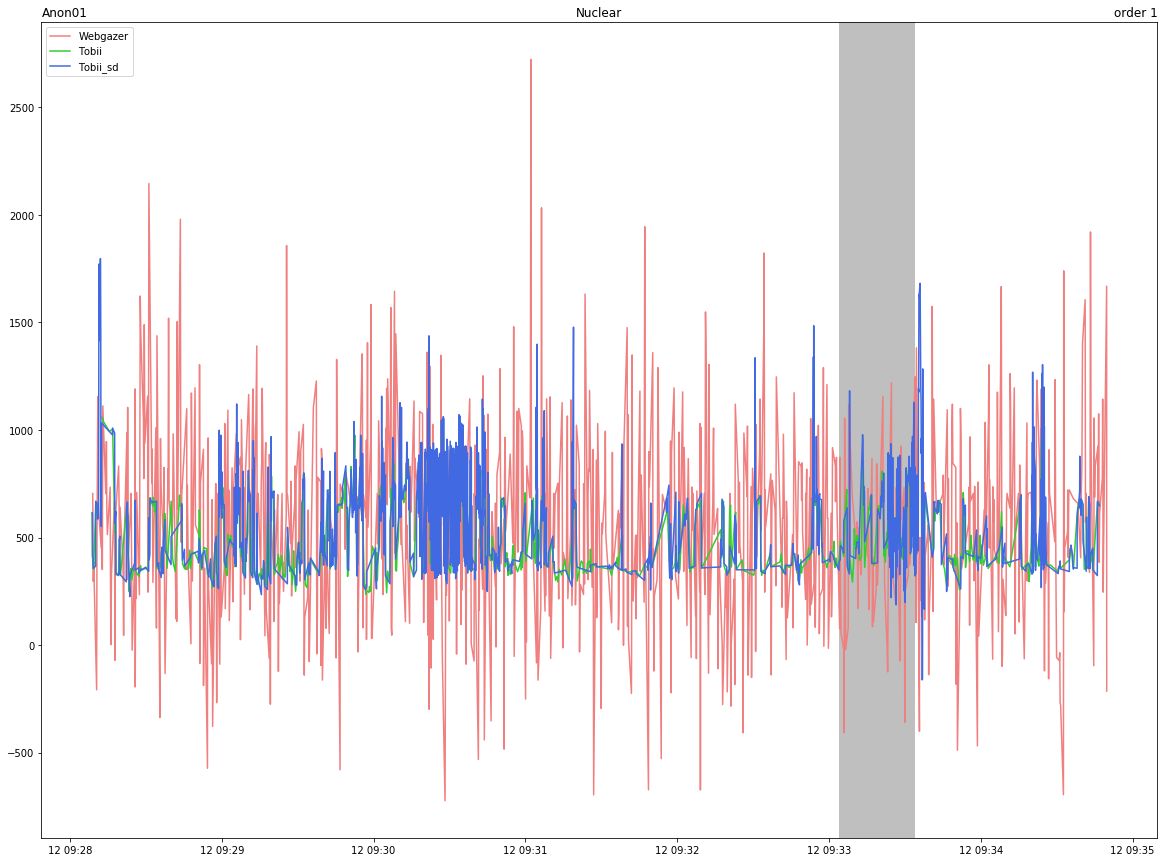

(1719, 9)
(836, 9)
(2088, 9)
(4, 10)


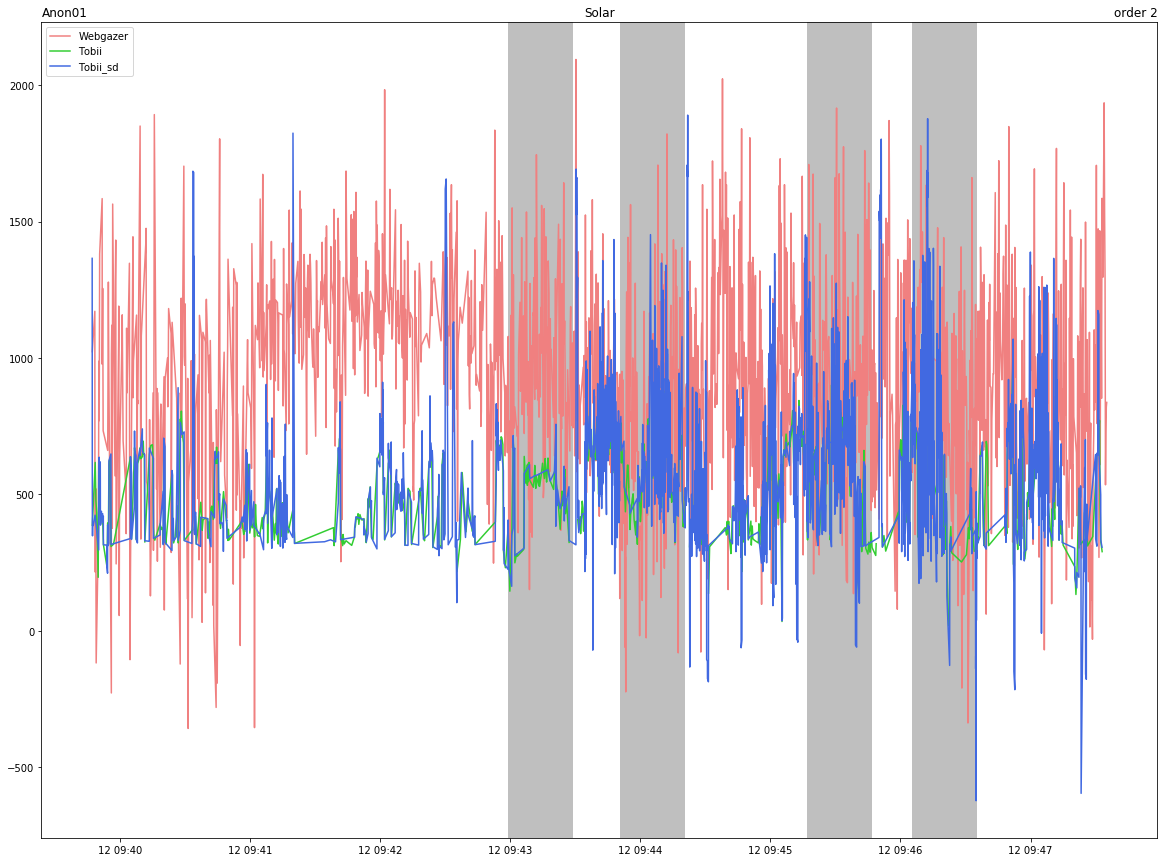

Anon02
(1595, 9)
(1503, 9)
(2006, 9)
(3, 10)


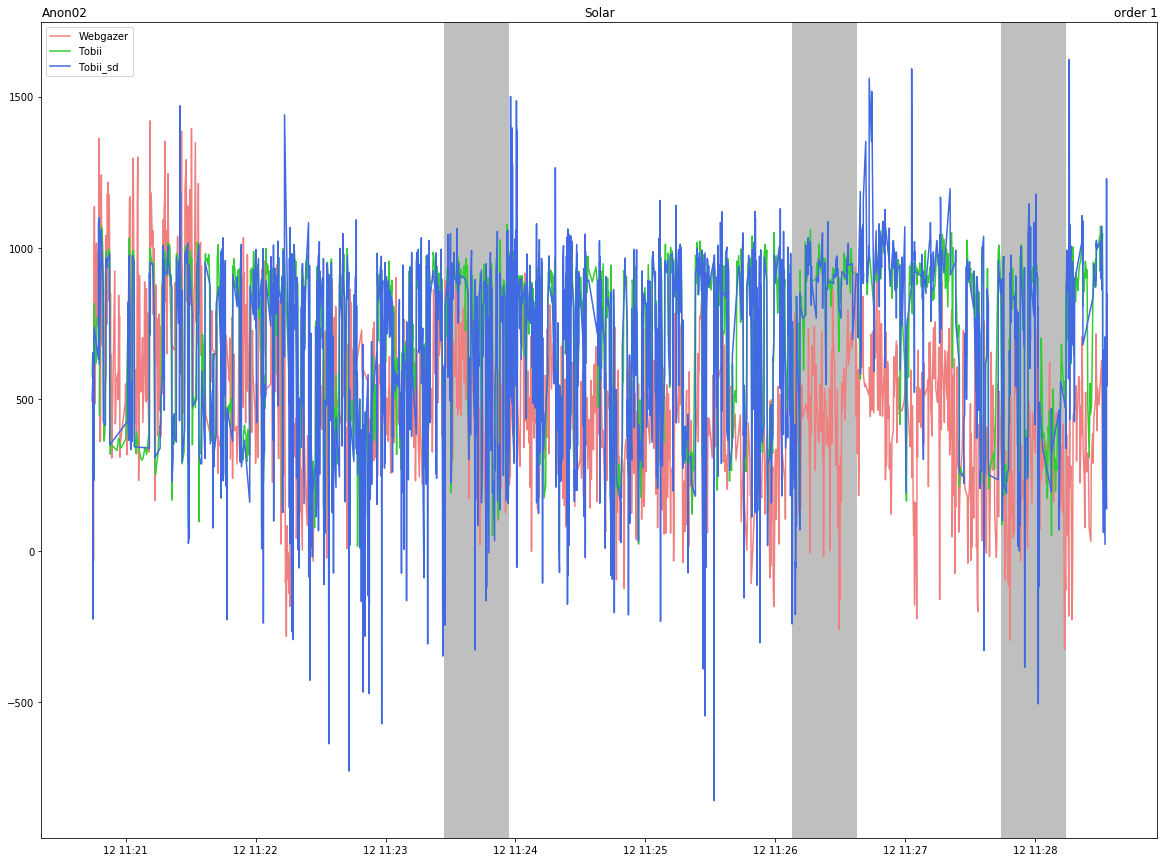

(1951, 9)
(1328, 9)
(2051, 9)
(4, 10)


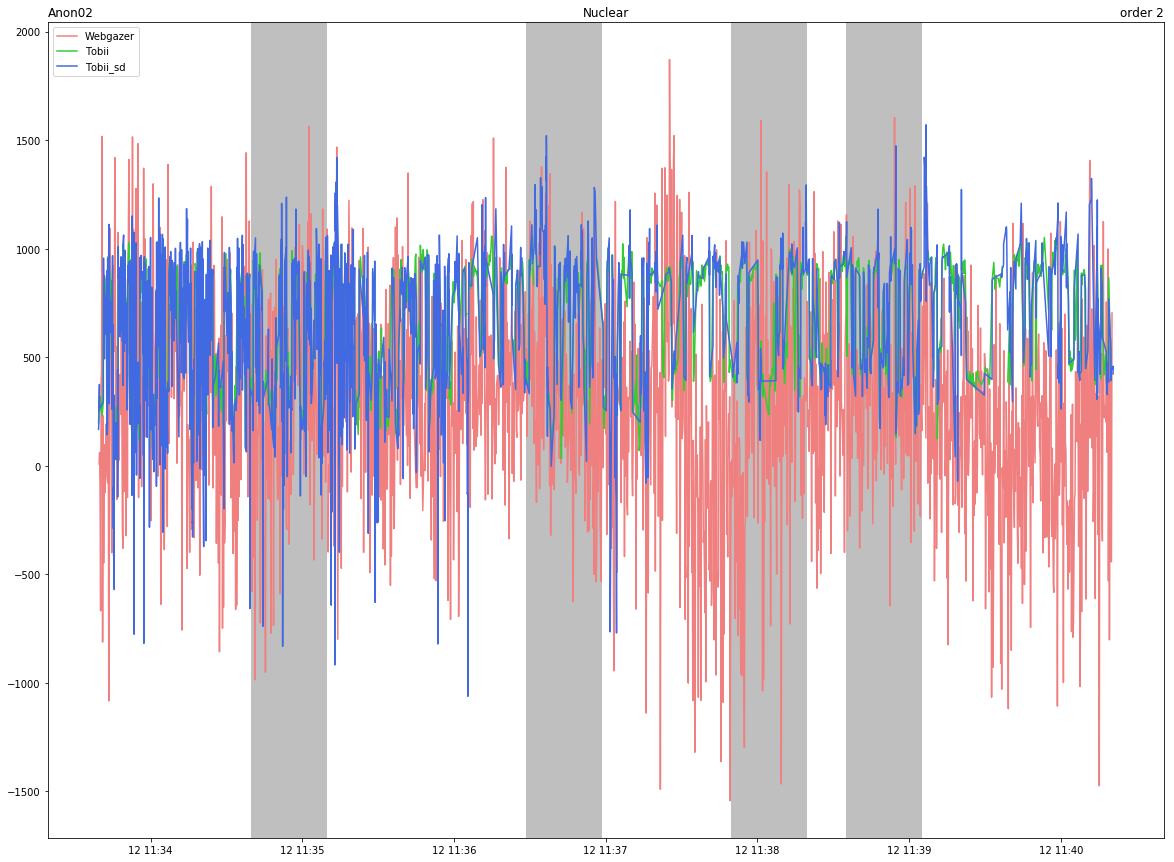

Anon03
(1732, 9)
(1273, 9)
(2007, 9)
(3, 10)


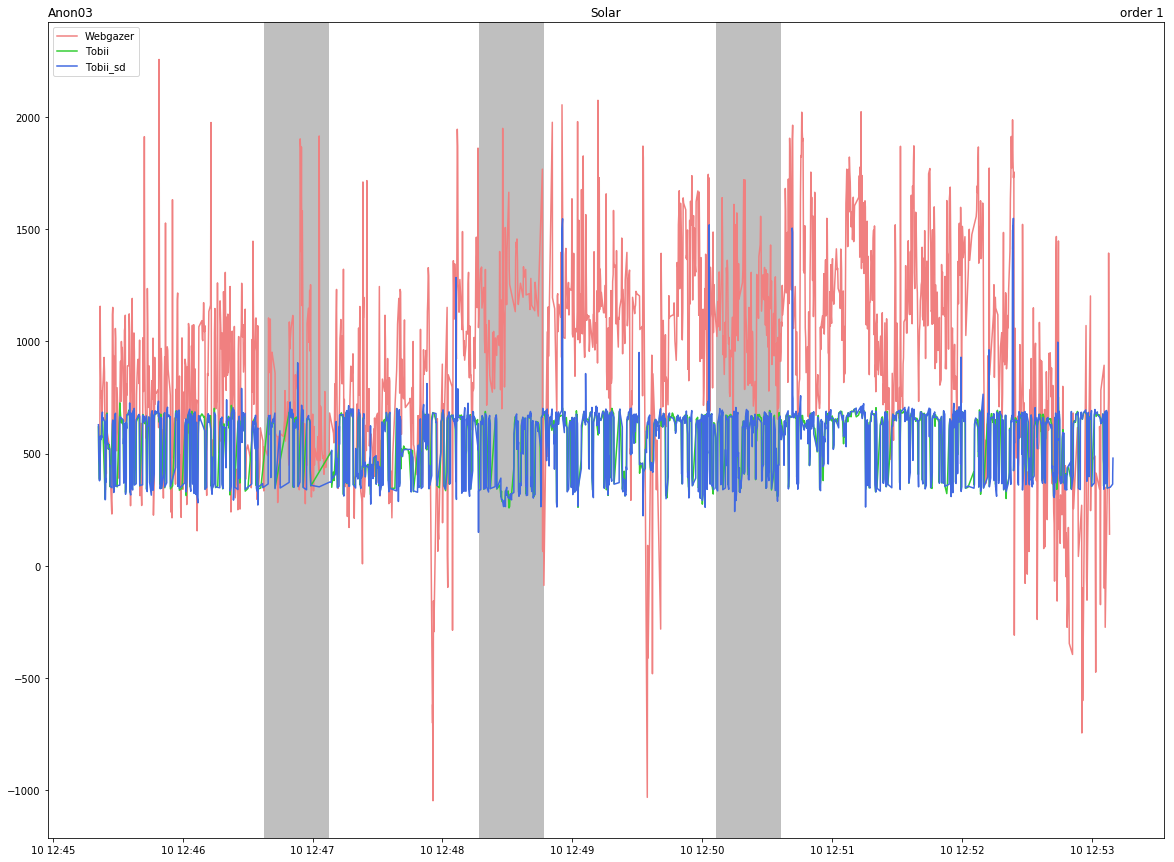

(1767, 9)
(1202, 9)
(1815, 9)
(3, 10)


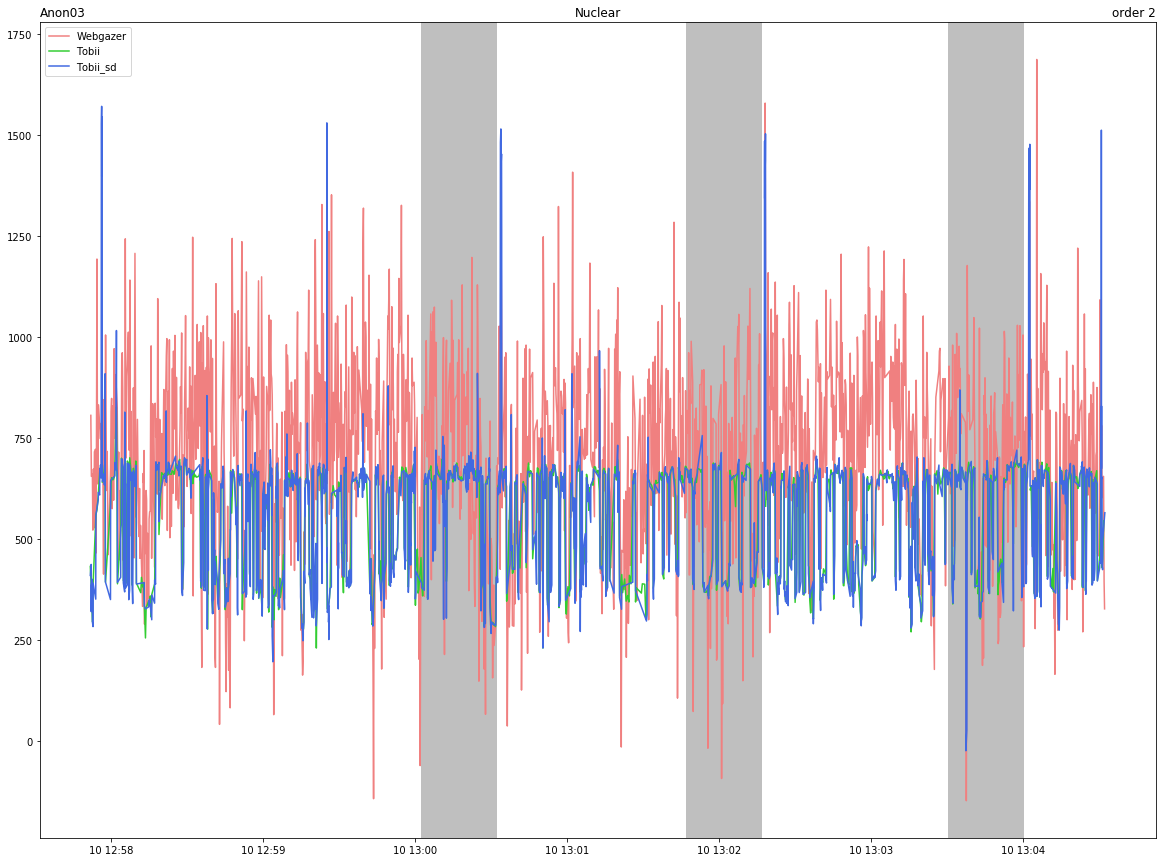

Anon04
(1946, 9)
(1316, 9)
(2209, 9)
(2, 10)


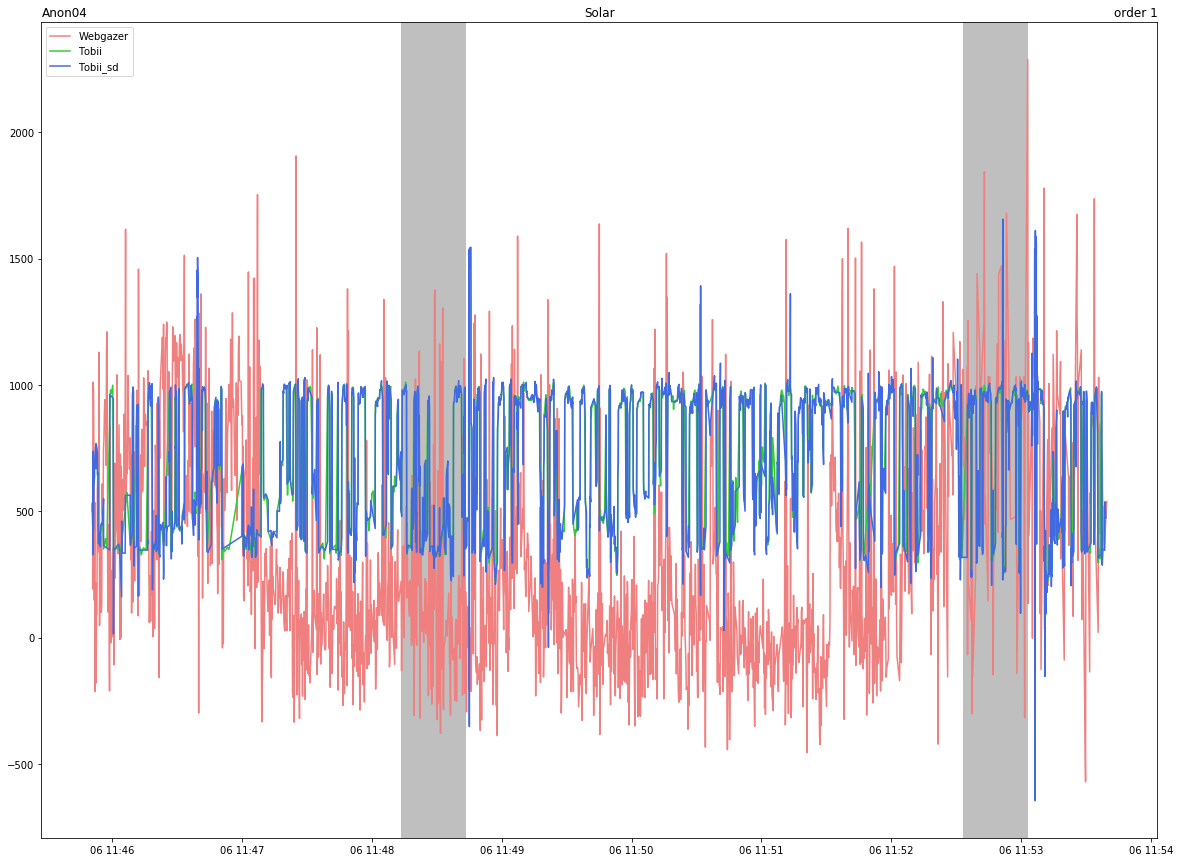

(1506, 9)
(1246, 9)
(2330, 9)
(2, 10)


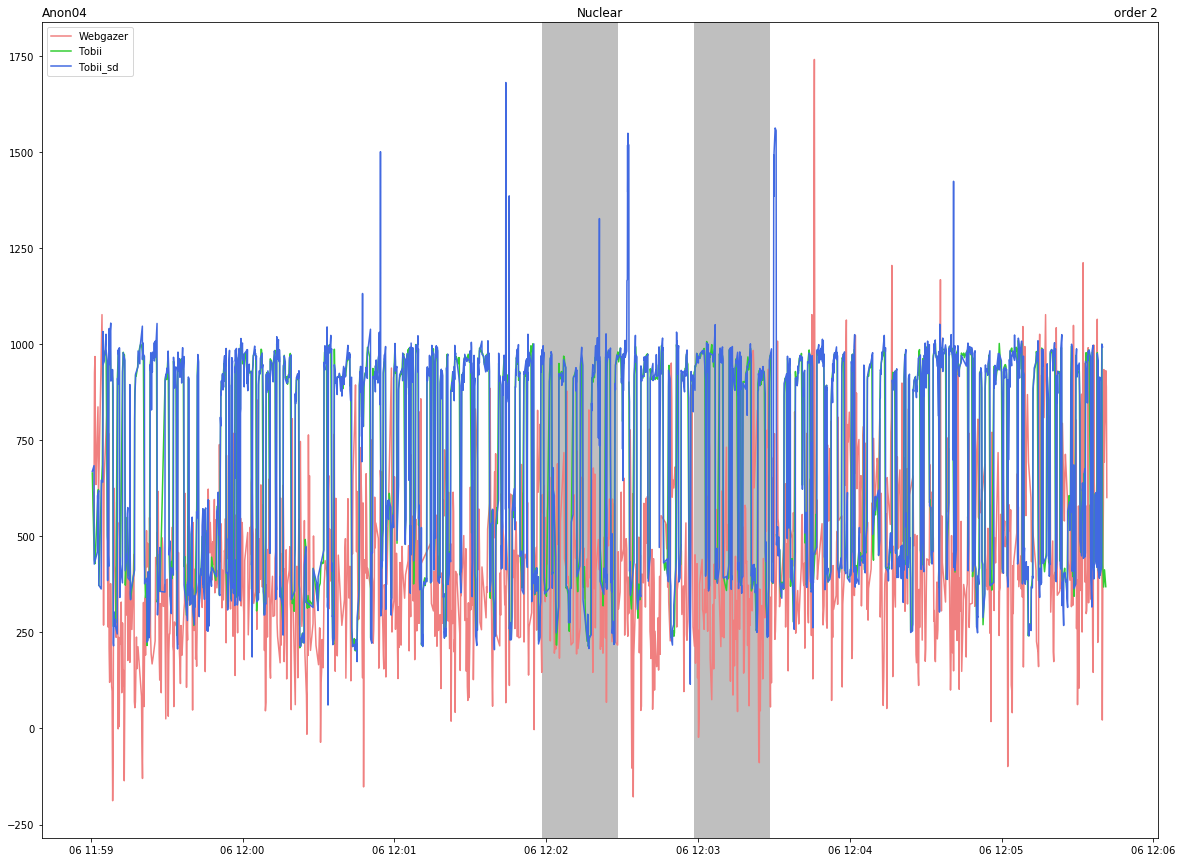

Anon05
(1468, 9)
(1013, 9)
(2067, 9)
(2, 10)


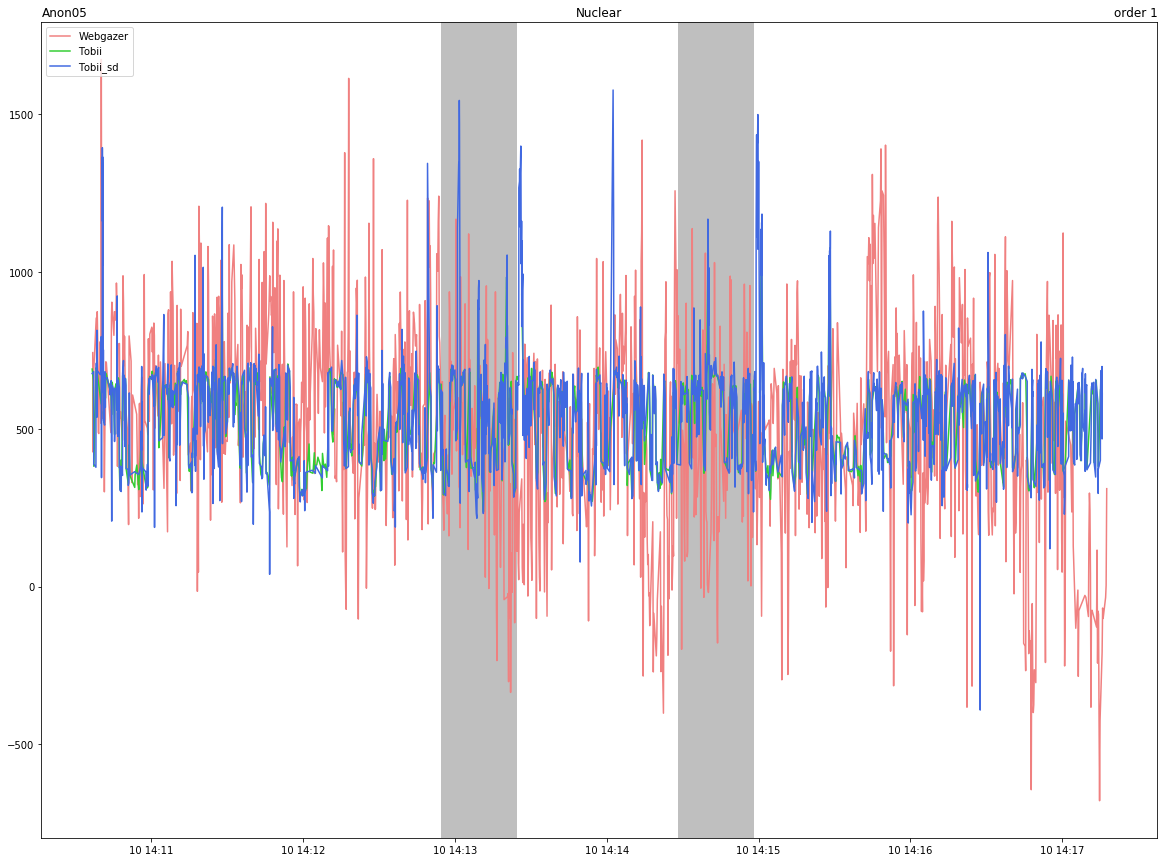

(2082, 9)
(1119, 9)
(2154, 9)
(2, 10)


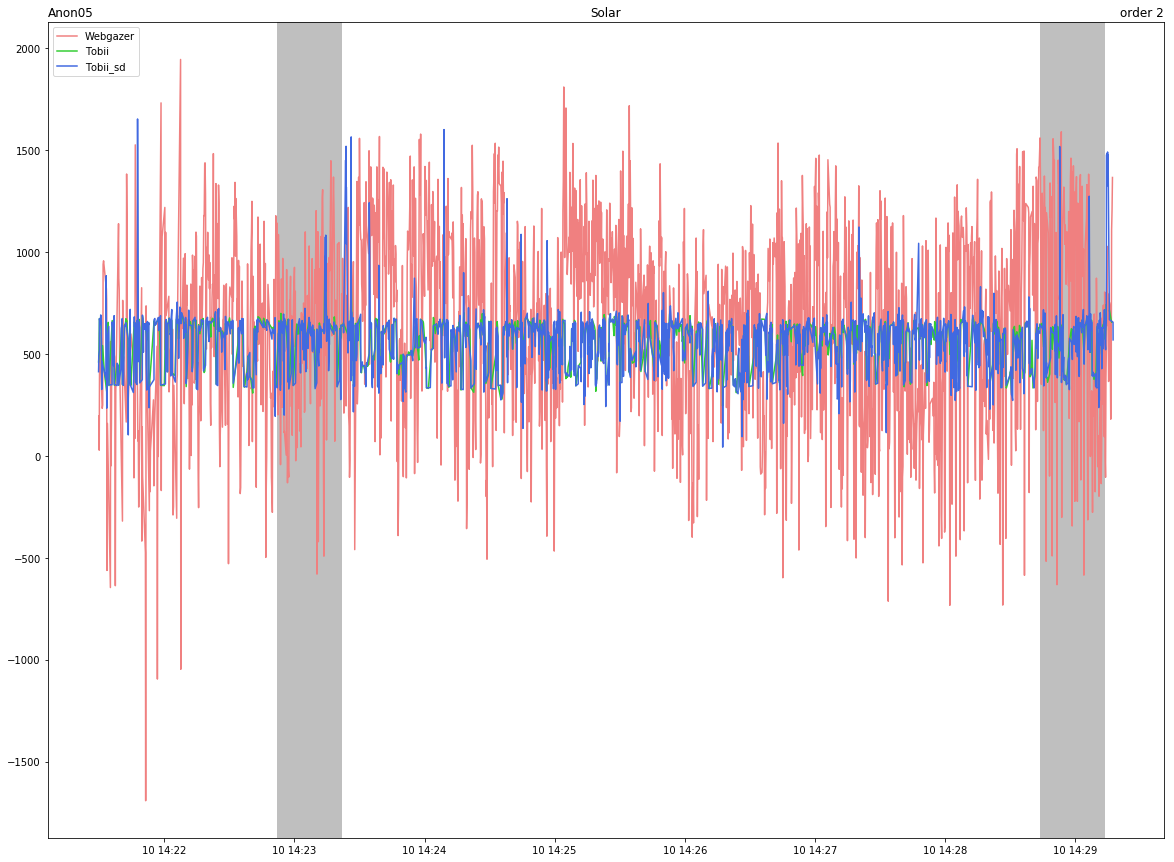

Anon06
(1322, 9)
(986, 9)
(1470, 9)
(0, 10)


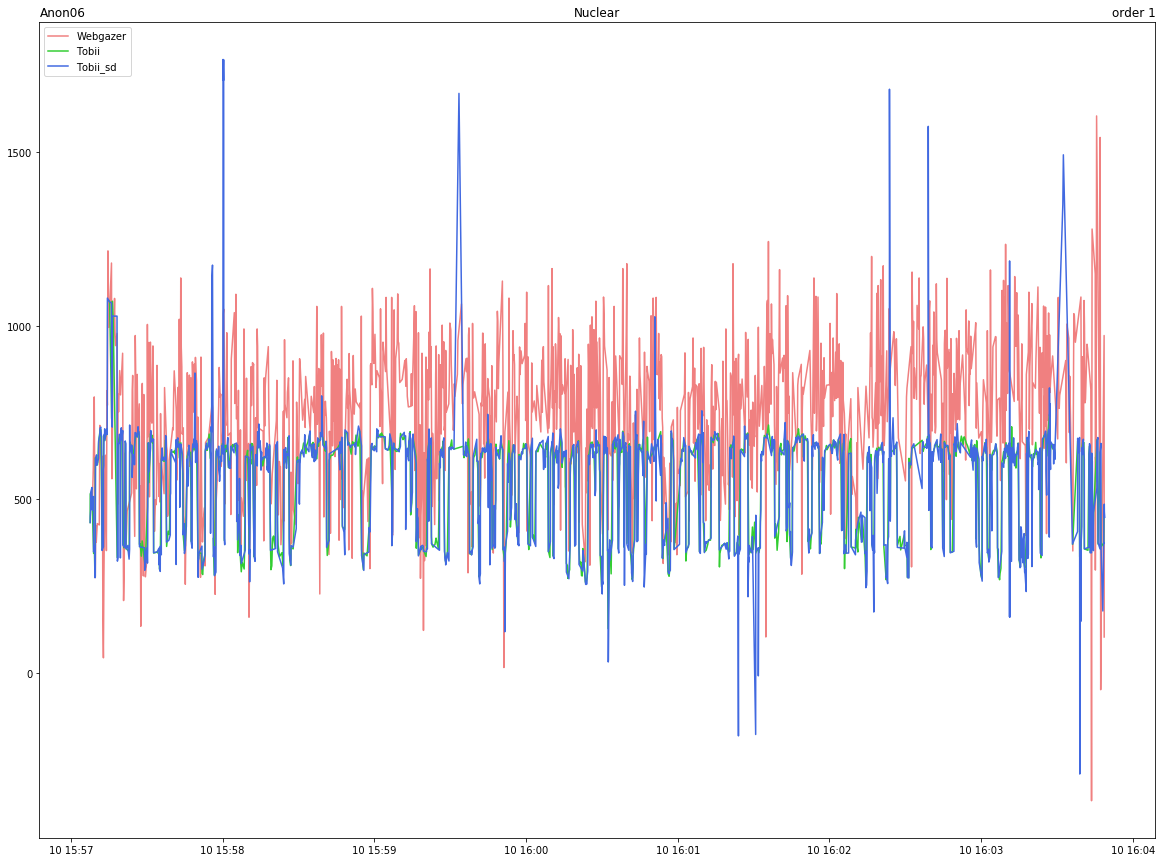

(1179, 9)
(1124, 9)
(1690, 9)
(1, 10)


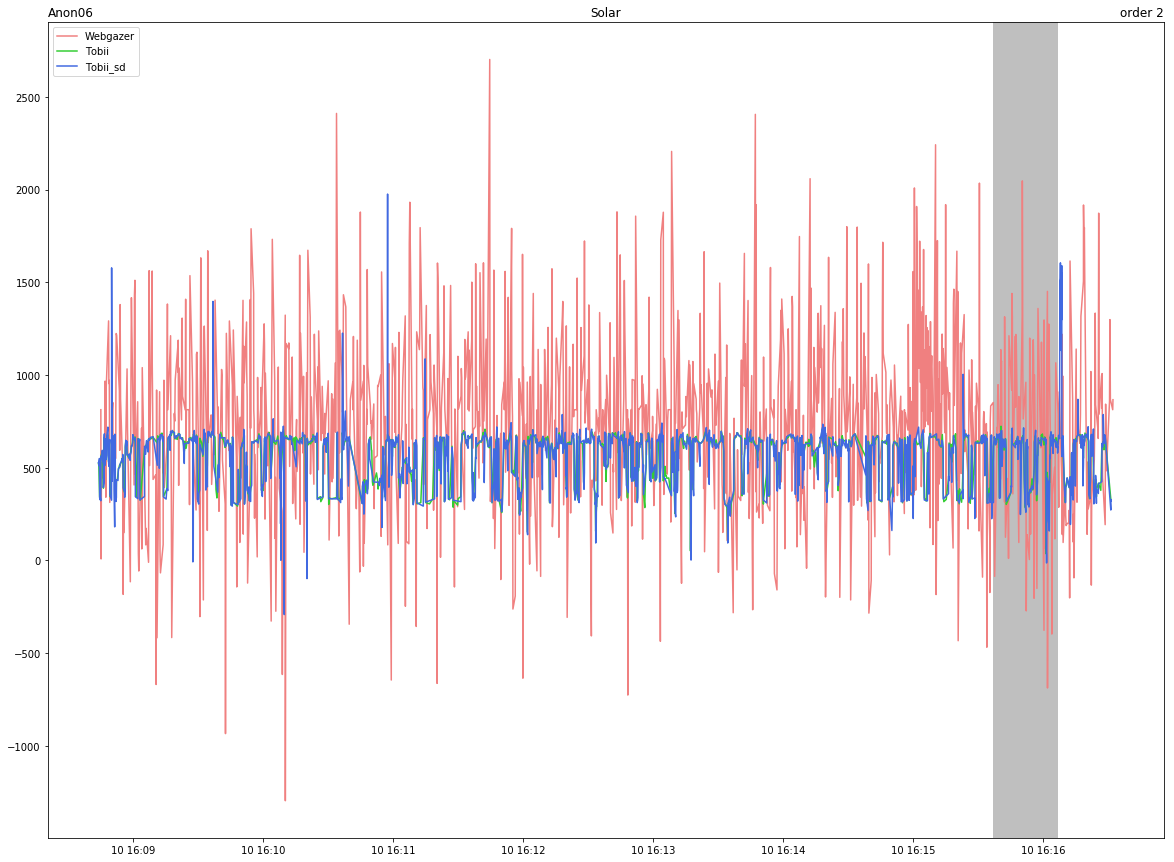

Anon07
(1720, 9)
(1107, 9)
(1904, 9)
(0, 10)


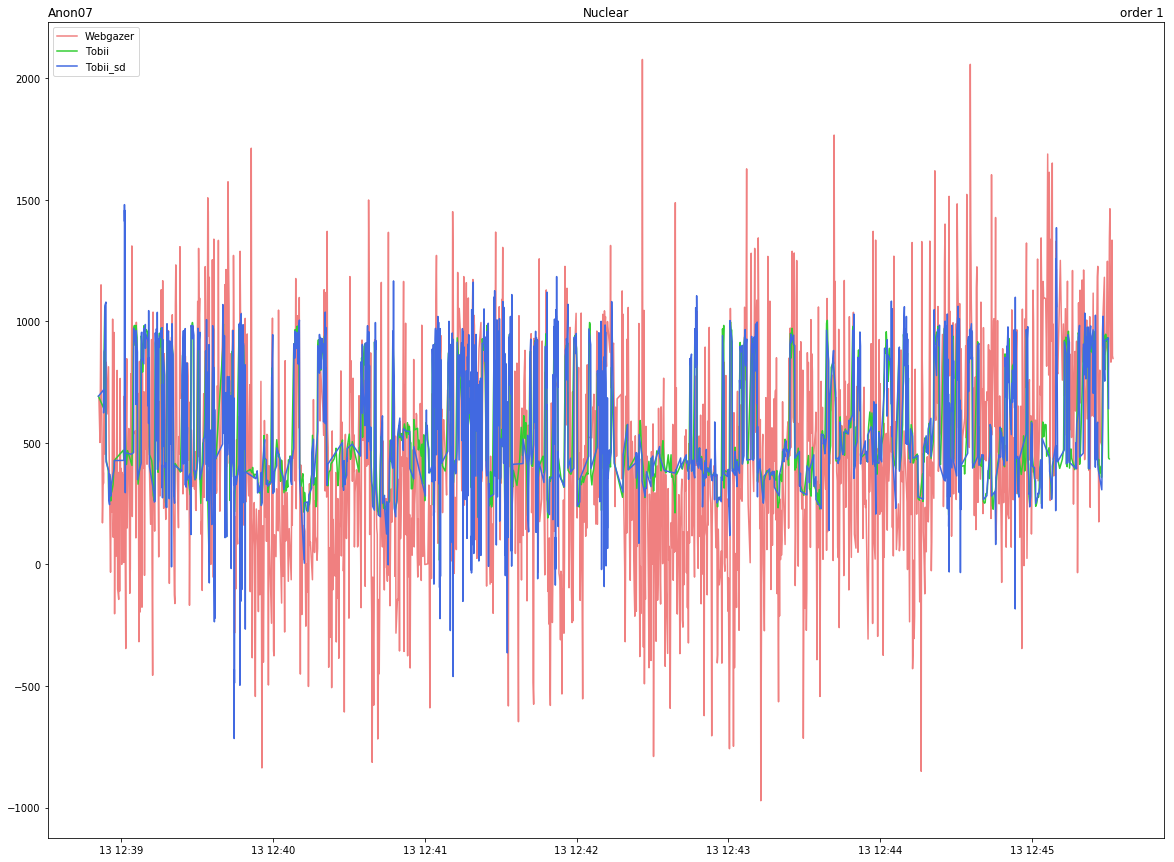

(1963, 9)
(1262, 9)
(2335, 9)
(1, 10)


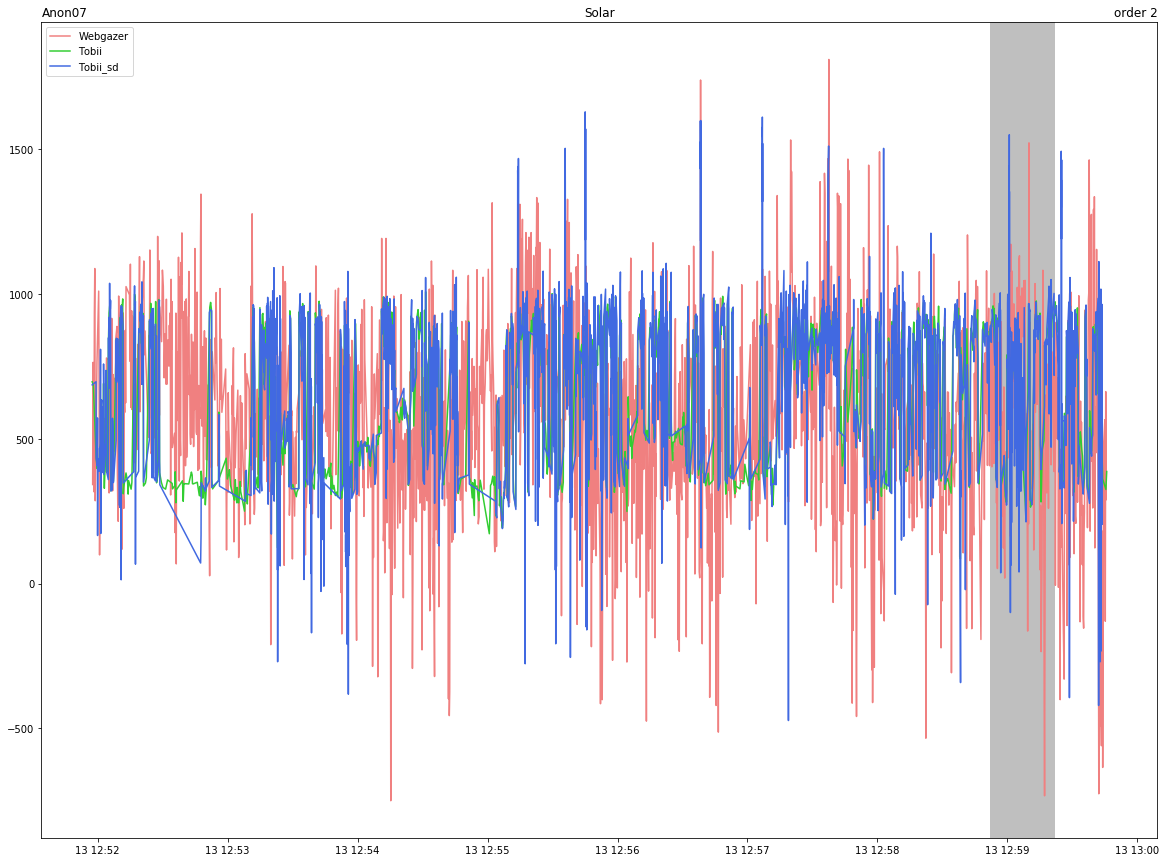

Anon08
(1778, 9)
(988, 9)
(1264, 9)
(1, 10)


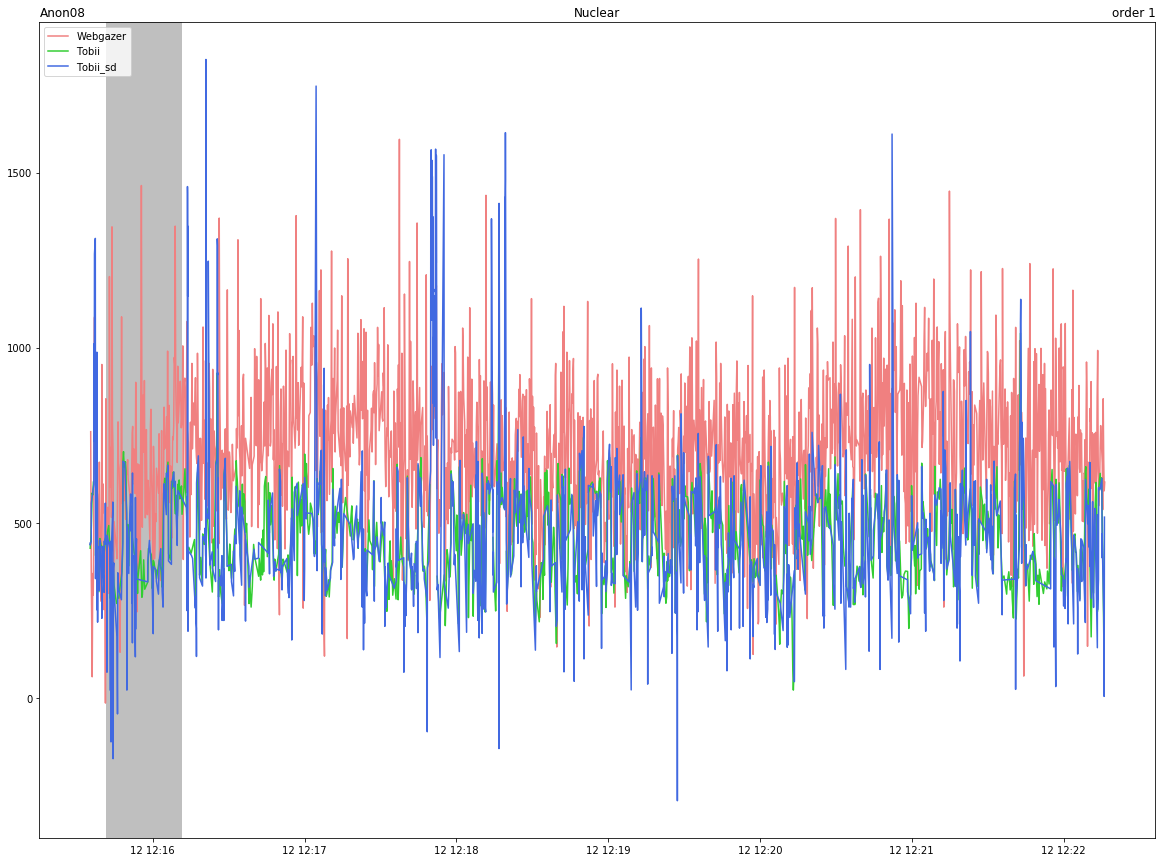

(1956, 9)
(1124, 9)
(1468, 9)
(1, 10)


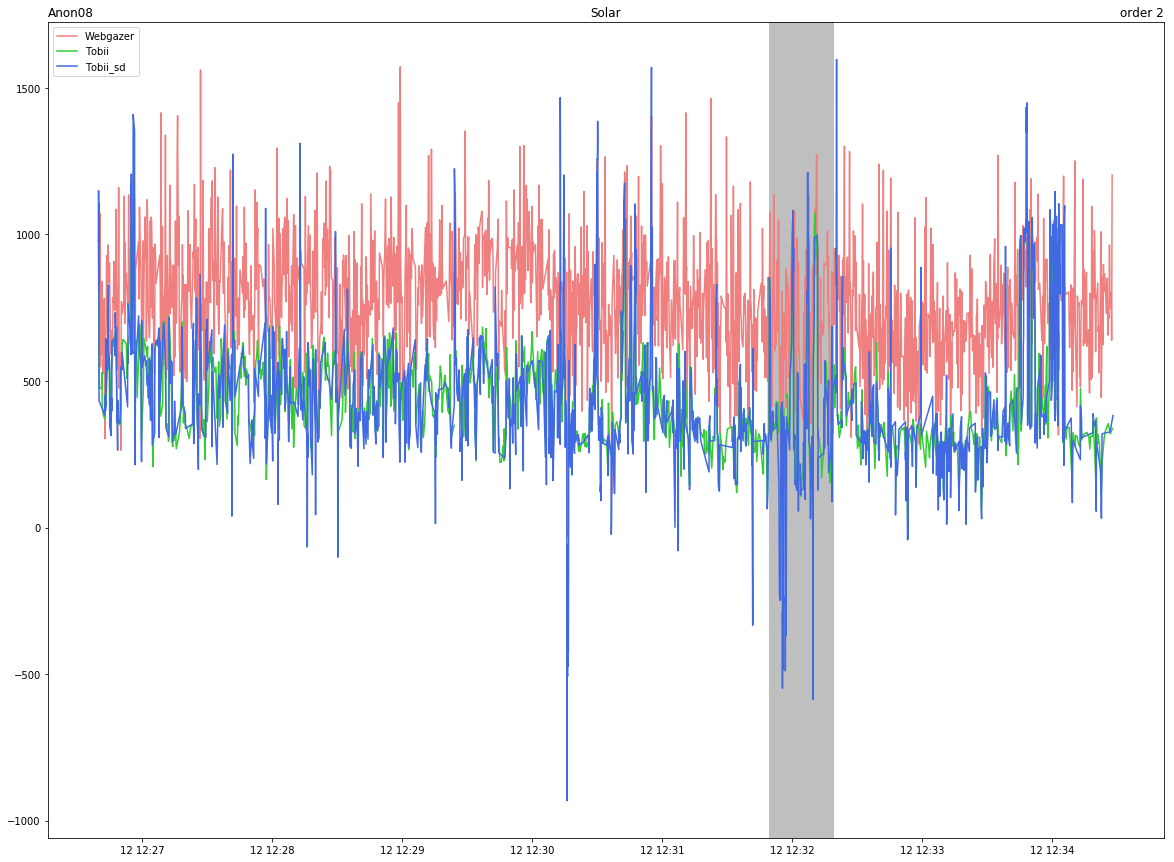

Anon09
(1585, 9)
(922, 9)
(1665, 9)
(3, 10)


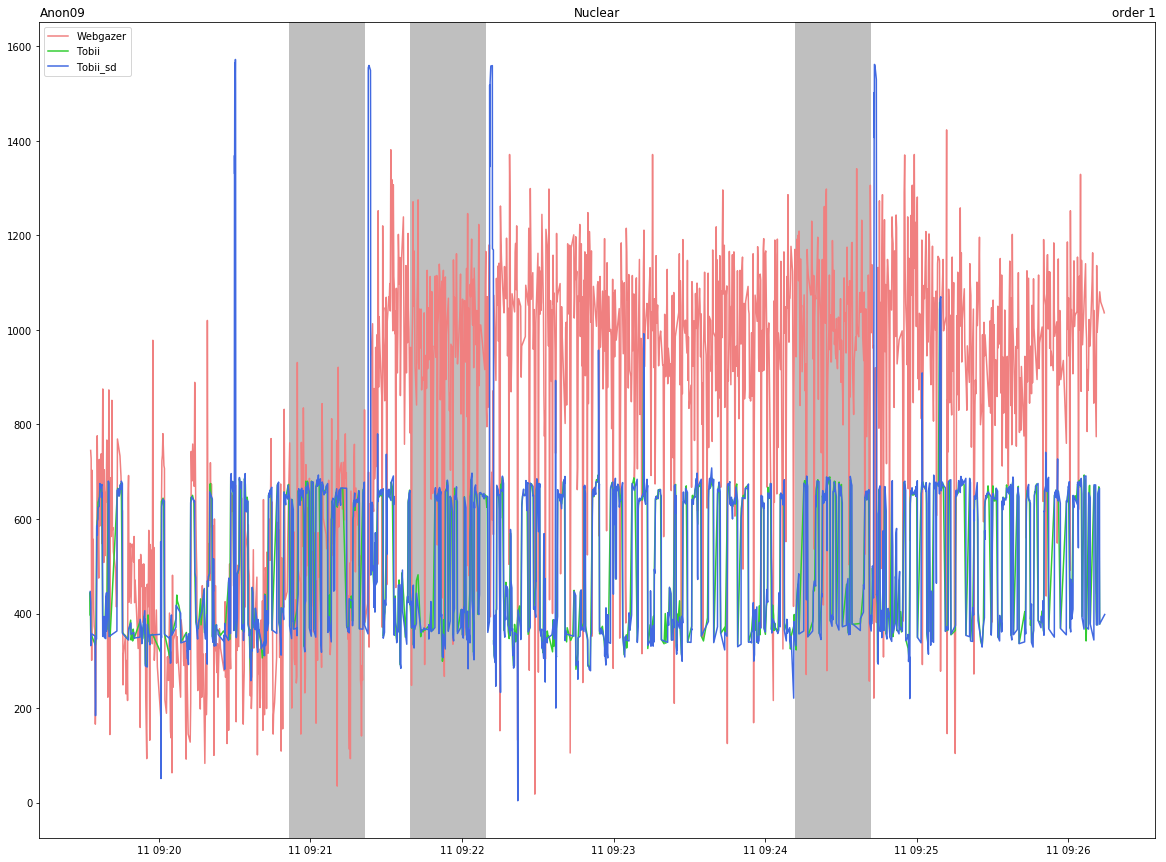

(2081, 9)
(1044, 9)
(1869, 9)
(6, 10)


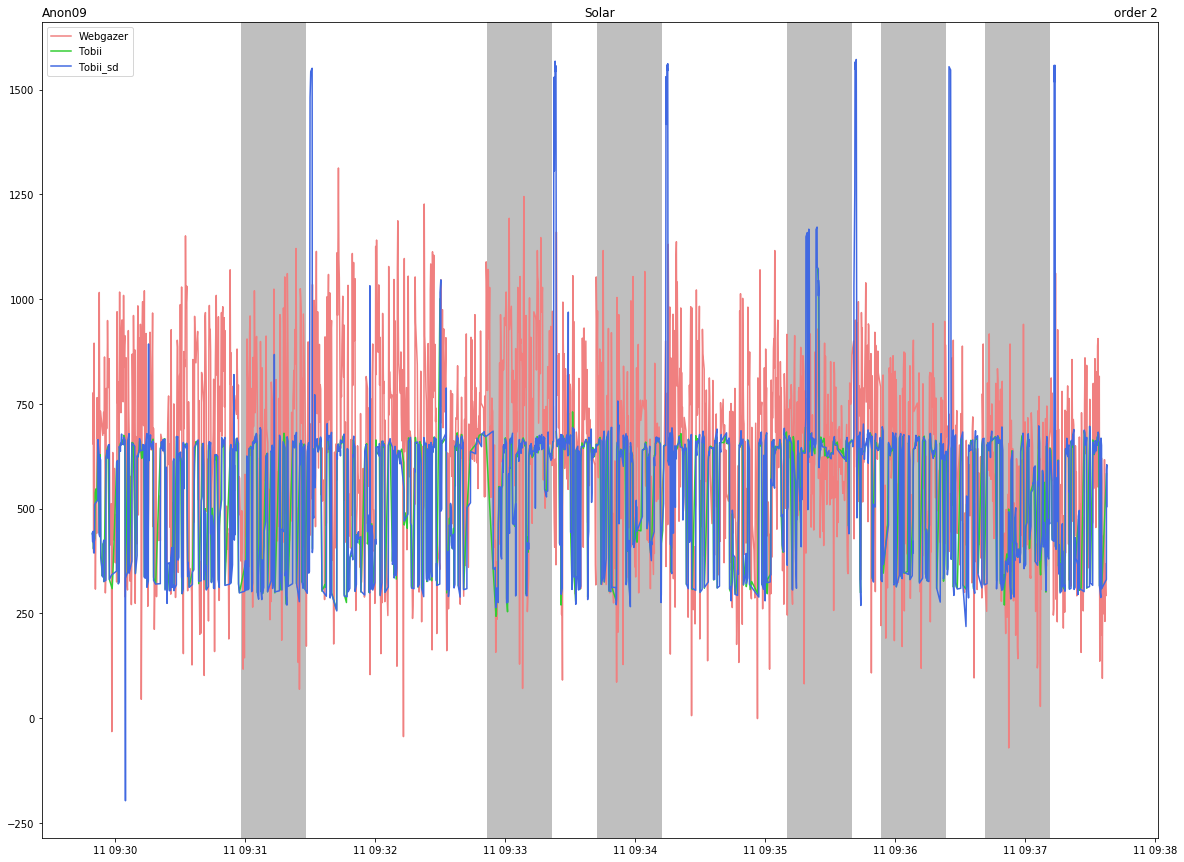

Anon10
(2113, 9)
(1066, 9)
(1180, 9)
(2, 10)


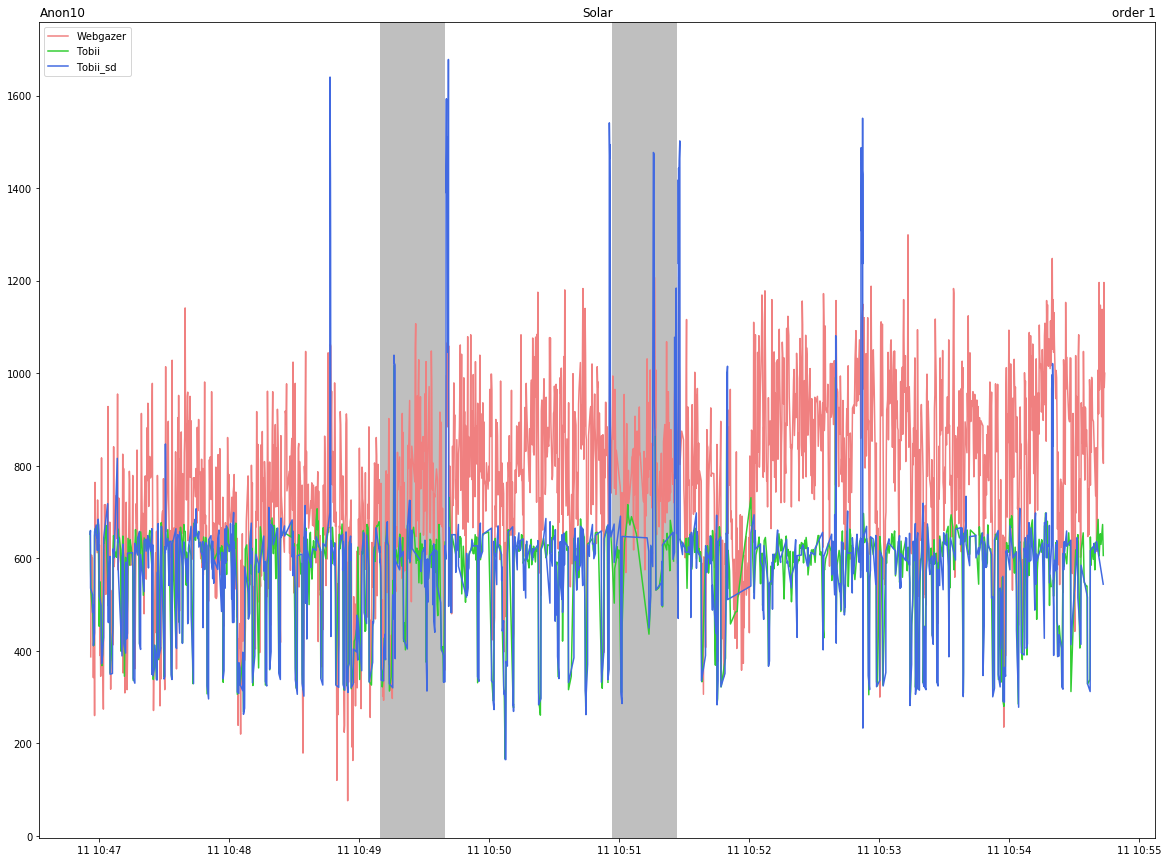

(1731, 9)
(964, 9)
(1186, 9)
(3, 10)


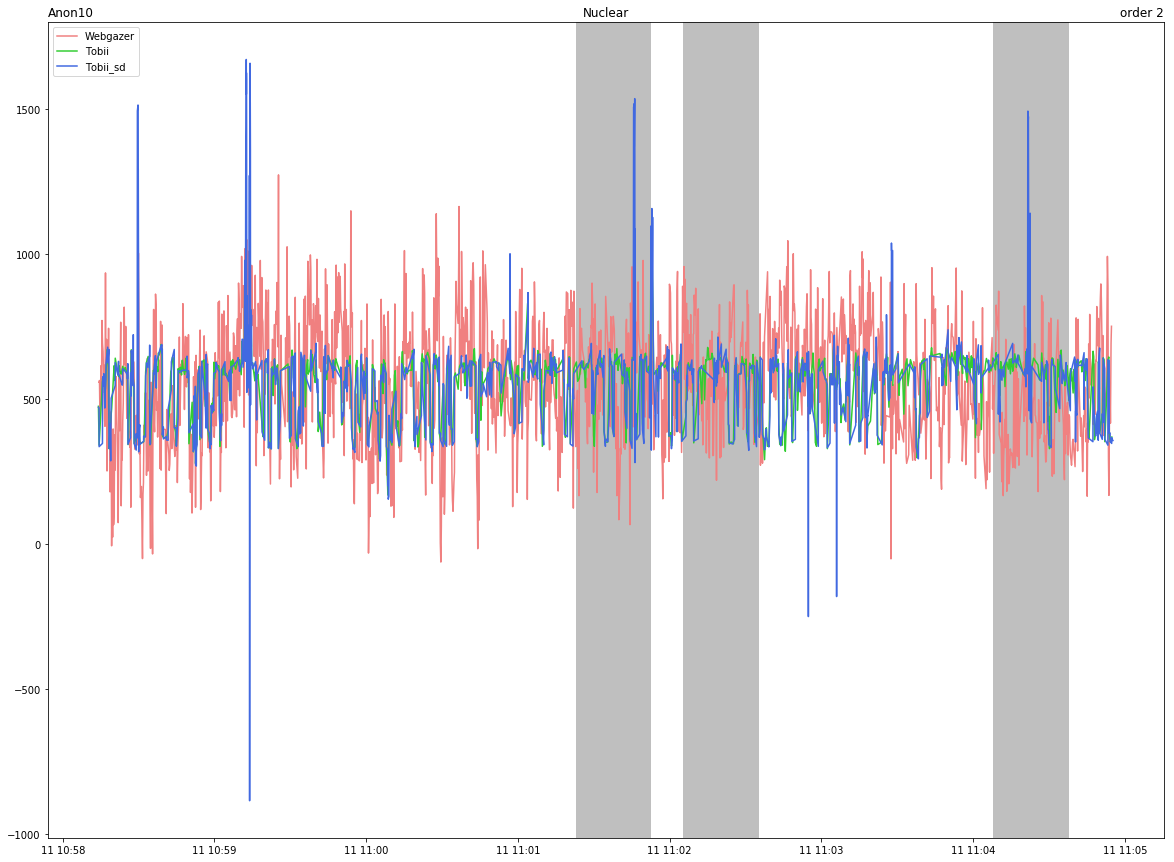

Anon11
(2072, 9)
(943, 9)
(1786, 9)
(3, 10)


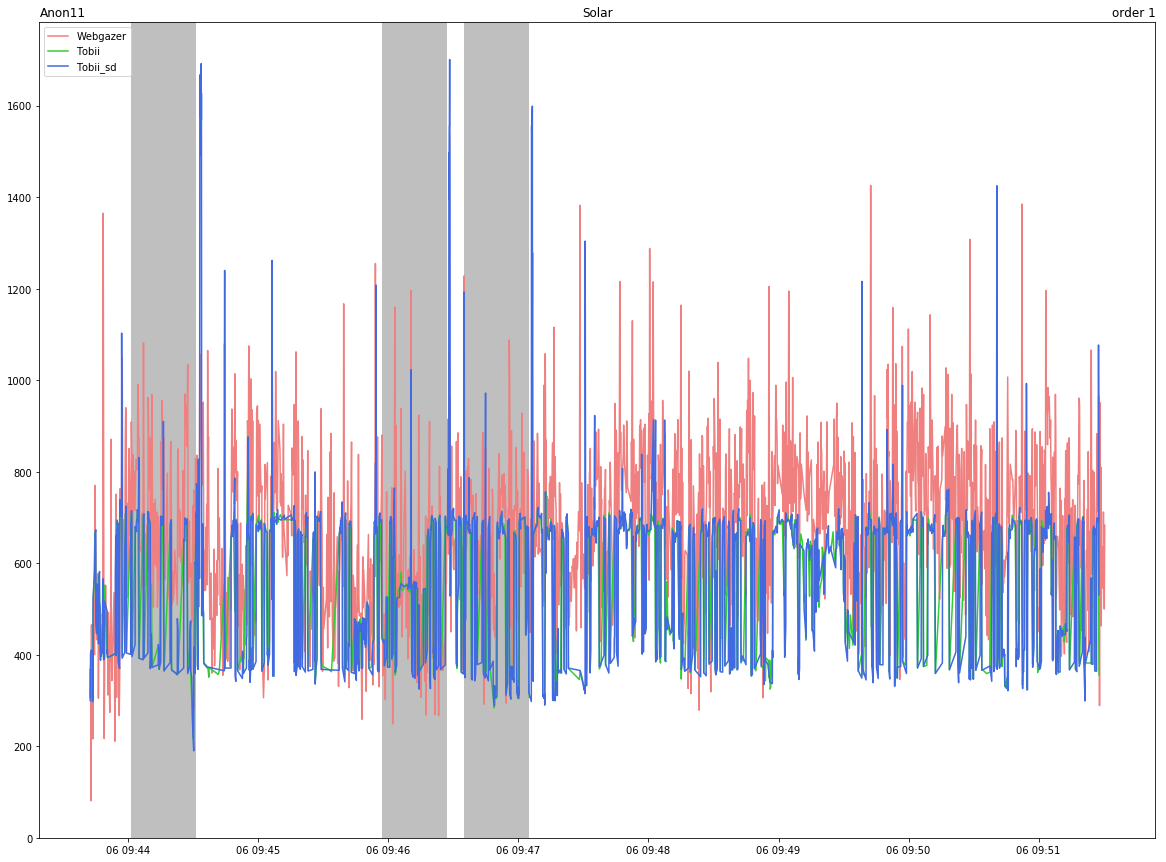

(1668, 9)
(798, 9)
(1514, 9)
(6, 10)


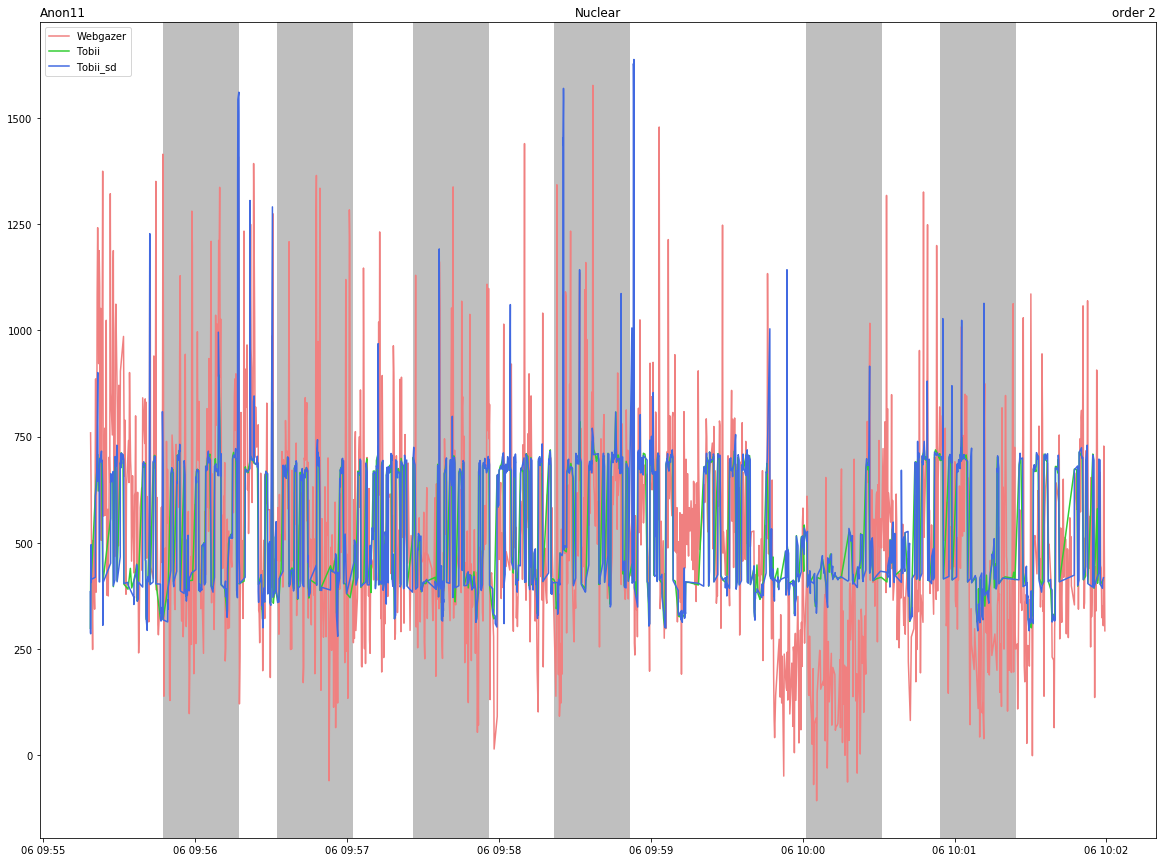

Anon12
(1596, 9)
(1390, 9)
(1481, 9)
(2, 10)


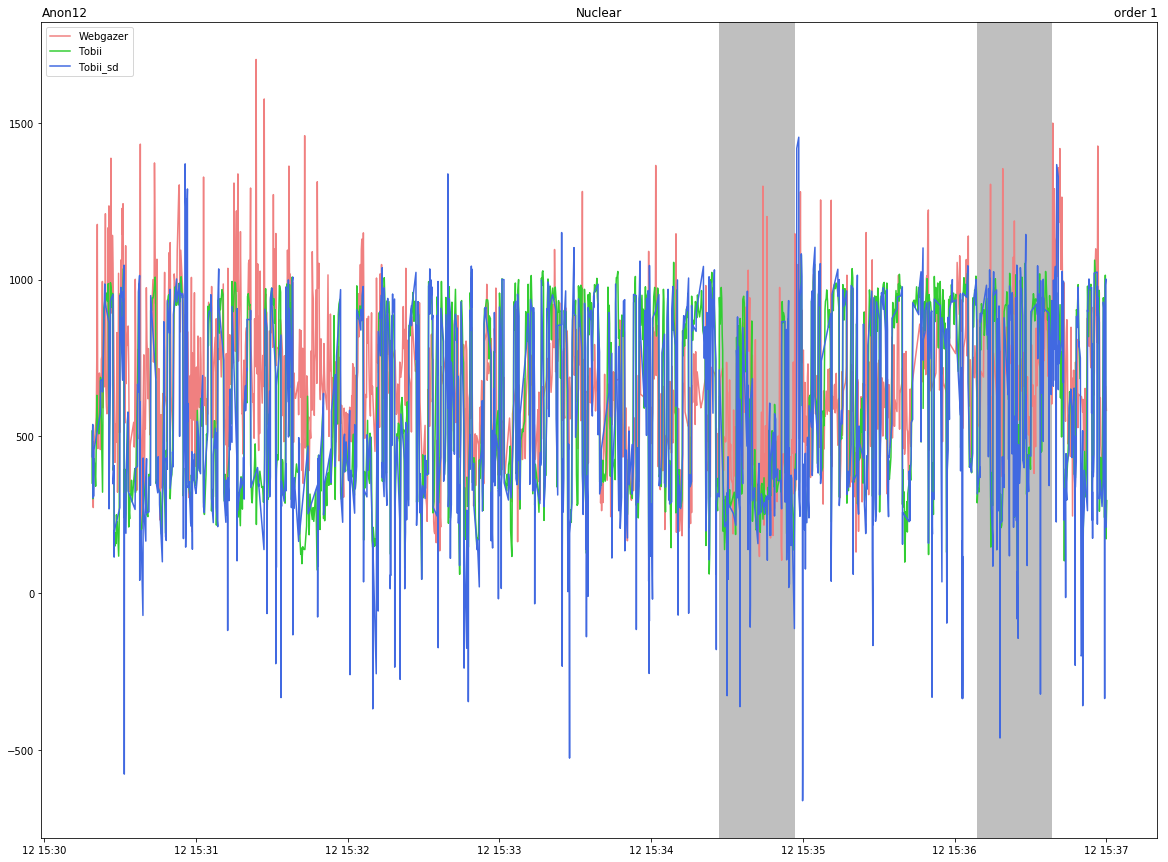

(2176, 9)
(1468, 9)
(1418, 9)
(2, 10)


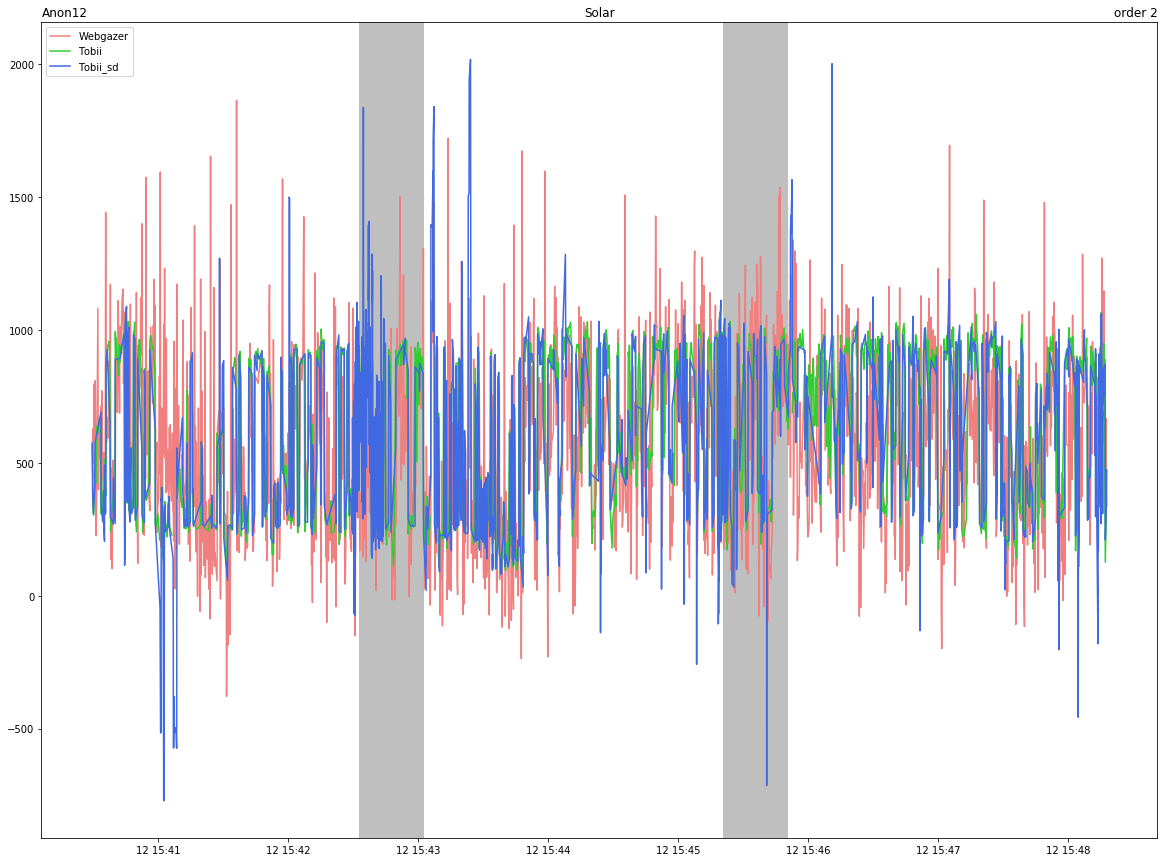

Anon13
(2047, 9)
(1193, 9)
(2607, 9)
(1, 10)


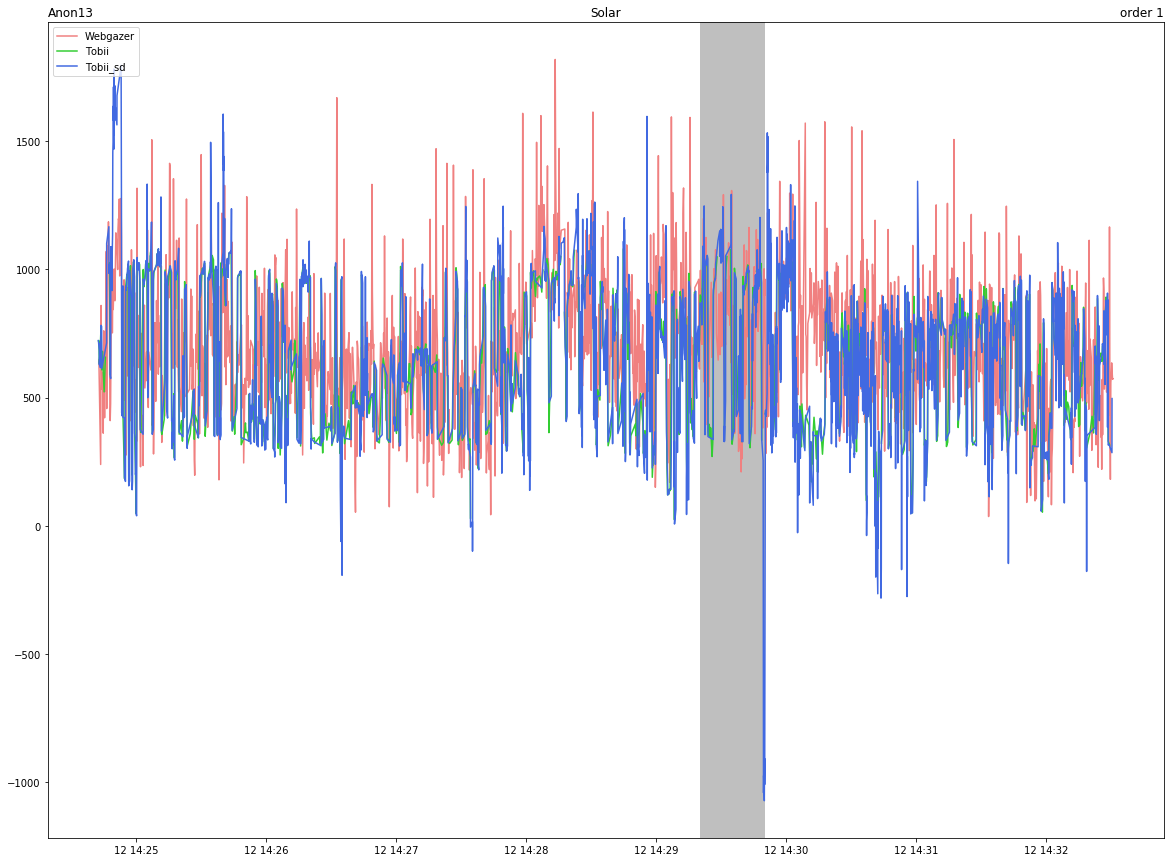

(1739, 9)
(1153, 9)
(2684, 9)
(0, 10)


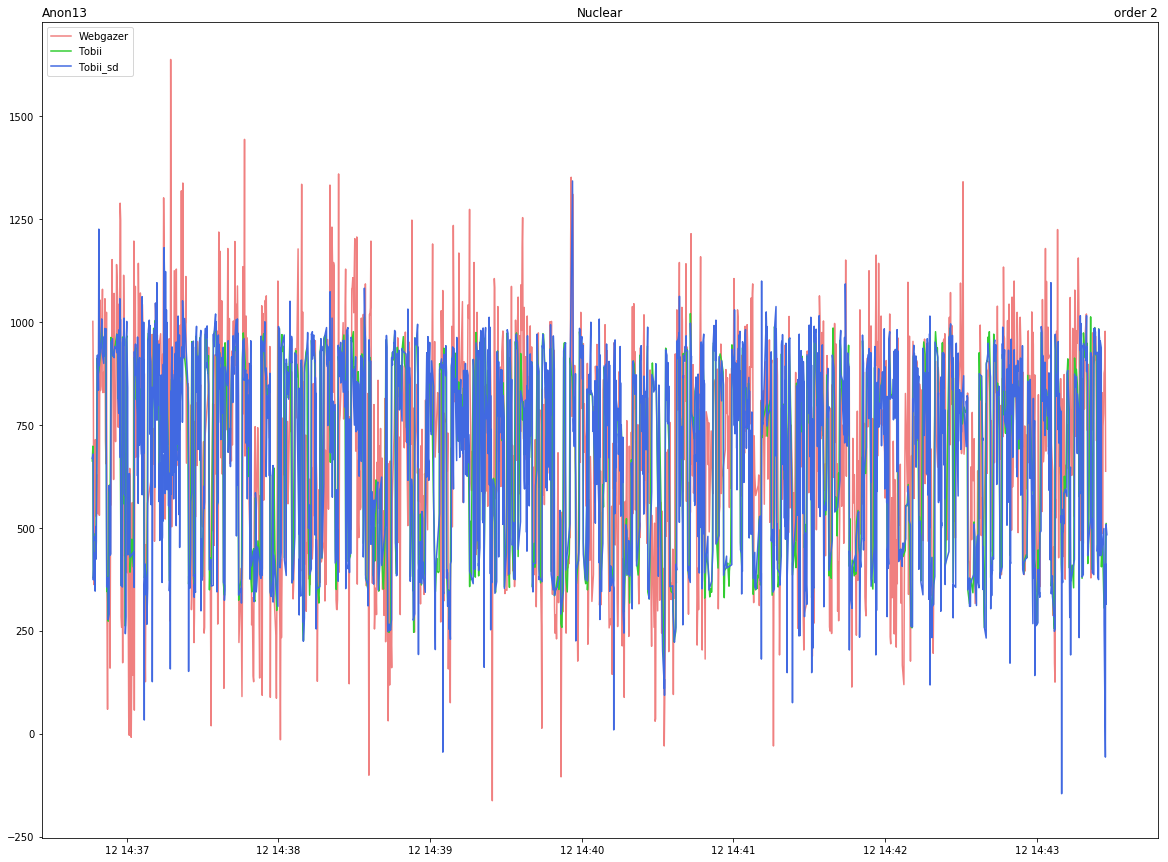

In [53]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

for id_index in range(0, len(list_id_report)):
    id_str = list_id_report[id_index]
    temp_videos = df_videos.loc[df_videos['id'] == id_str]
    print id_str
    for index, row in temp_videos.iterrows():
        video_id = row["video_id"]
        video_order = row["video_order"]
        
        temp_df_webgazer = df_fixations_webgazer.loc[(df_fixations_webgazer['id'] == id_str) & 
                                                     (df_fixations_webgazer['video_id'] == video_id)]
        print temp_df_webgazer.shape
        x_webgazer = np.array([datetime.datetime.strptime(i, "%Y-%m-%dT%H:%M:%S.%fZ") for i in temp_df_webgazer['fixation_starttime_iso']])
        y_webgazer = temp_df_webgazer['fixation_Y']

        temp_df_tobii_tf = df_fixations_tobii_tf.loc[(df_fixations_tobii_tf['id'] == id_str) &
                                                     (df_fixations_tobii_tf['video_id'] == video_id)]
        print temp_df_tobii_tf.shape
        x_tobii_tf = np.array([datetime.datetime.strptime(j, "%Y-%m-%dT%H:%M:%S.%fZ") for j in temp_df_tobii_tf['fixation_starttime_iso']])
        y_tobii_tf = temp_df_tobii_tf['fixation_Y']

        temp_df_tobii_sac = df_fixations_tobii_sac.loc[(df_fixations_tobii_sac['id'] == id_str) &
                                                       (df_fixations_tobii_sac['video_id'] == video_id)]
        print temp_df_tobii_sac.shape
        x_tobii_sac = np.array([datetime.datetime.strptime(k, "%Y-%m-%dT%H:%M:%S.%fZ") for k in temp_df_tobii_sac['fixation_starttime_iso']])
        y_tobii_sac = temp_df_tobii_sac['fixation_Y']

        plt.figure(figsize=(20,15))
        plt.plot(x_webgazer,y_webgazer, color="lightcoral")
        plt.plot(x_tobii_tf, y_tobii_tf, color="limegreen")
        plt.plot(x_tobii_sac,y_tobii_sac, color="royalblue")
        plt.legend(['Webgazer', 'Tobii', 'Tobii_sd'], loc='upper left')
        plt.title(video_id)
        plt.title(id_str, loc='left')
        plt.title("order " + str(video_order), loc='right')

        temp_report =  df_reports.loc[(df_reports['id'] == id_str) & 
                                      (df_reports['video_id'] == video_id) & 
                                      (df_reports['label'] == 1)]
        print temp_report.shape
        for index, row in temp_report.iterrows():
            starttime = datetime.datetime.strptime(row['starttime_iso'], "%Y-%m-%dT%H:%M:%S.%fZ")
            endtime = datetime.datetime.strptime(row['endtime_iso'], "%Y-%m-%dT%H:%M:%S.%fZ")
            plt.axvspan(starttime, endtime, facecolor='grey', alpha=0.5)

        plt.show()